<a href="https://colab.research.google.com/github/anastasiiaCher/pyad-2024/blob/main/lab4/PY%D0%90%D0%94_%D0%9B%D0%A04_Text_Processing_%26_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")
sns.set_theme("notebook")
sns.set_style("whitegrid")
sns.set_palette("Dark2")

# Постановка задачи и загрузка данных

В рамках лабораторной работы поработаем снова с реальными данными, содержательно близкими к данным минус первой лабораторной, - про учебные дисциплины. В этот раз займемся обработкой и генерацией описания и содержания дисциплин с помощью языковых моделей.

## Данные

Расположены по ссылке.

In [4]:
!gdown 1k1drlKxdqLgw_y_iMgSkBuZwa2Gjc6Q1

Downloading...
From: https://drive.google.com/uc?id=1k1drlKxdqLgw_y_iMgSkBuZwa2Gjc6Q1
To: /content/disciplines_2018_2022.csv
100% 78.8M/78.8M [00:00<00:00, 83.1MB/s]


Из информации о дисциплине у нас есть следующая:
1. `course_id` - номер дисциплины (может повторяться)
2. `course_title`` - название дисциплины
3. `description` - краткое описание дисциплины
4. `up_id` - айди учебного плана (образовательной прогарммы)
5. `up_title` - название учебного плана (образовательной прогарммы)
6. `qualification` - уровень образования (бакалавриат или магистратура)
7. `start_year` - год набора
8. `module_name` - название модуля, в который входит дисциплина
9. `contents` – содержание дисциплины (все темы и разделы не по порядку, сплошным текстом)

Данные уже частично предобработаны: датасет содержит только те дисциплины, которые реализовывались более одного года. Это примерно треть от всех дисциплин за 2018–2022 гг.

In [5]:
df = pd.read_csv("/content/disciplines_2018_2022.csv")
df.sample(3, random_state=42)

,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents
16112,17498,Создание технологического бизнеса,Цель курса - предоставить возможность магистра...,7198,Информационная безопасность / Information secu...,master,2022,Наукоемкое предпринимательство,Инновационный маркетинг. Корпоративные финансы...
2457,3002,Теория электрической связи,Программа составлена в соответствии с требован...,6989,Программирование в инфокоммуникационных системах,bachelor,2020,Модуль обязательных дисциплин,"Математические модели сигналов, помех и канало..."
1077,2736,Организация массовых мероприятий,Данная дисциплина учит планировать мероприятие...,6875,Управление технологическими инновациями,bachelor,2018,Модуль «Soft Skills»,Особенности организации массовых мероприятий.....


In [6]:
df.shape

(20502, 9)

Немного погрузимся в данные.

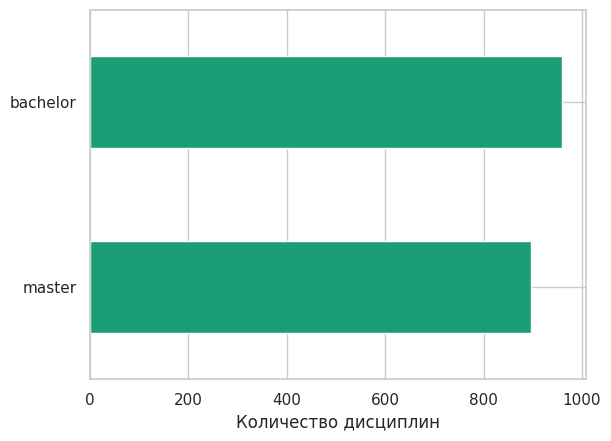

In [7]:
# количество дисциплин с уникальными названиями по уровням подготовки
df[["course_title", "qualification"]].drop_duplicates().qualification.value_counts().sort_values(ascending=True).plot(kind="barh")
plt.xlabel("Количество дисциплин")
plt.ylabel("")
plt.show()

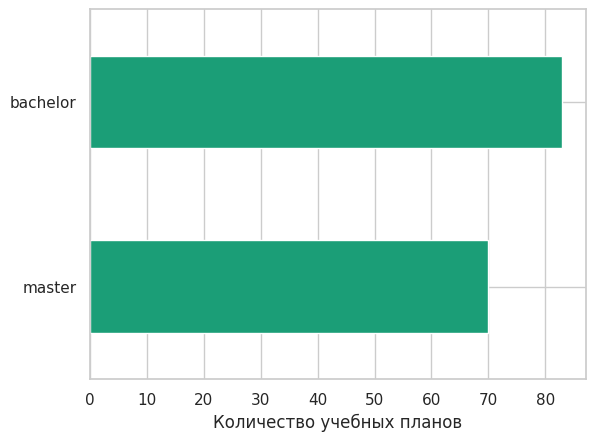

In [8]:
# количество учебных планов с уникальными названиями по уровням подготовки
df[["up_title", "qualification"]].drop_duplicates().qualification.value_counts().sort_values(ascending=True).plot(kind="barh")
plt.xlabel("Количество учебных планов")
plt.ylabel("")
plt.show()

Видим, что дисциплин больше (незначительно) в бакалавриате, но учебных планов больше в магистратуре. Это соответствует истине.

<s>Учебных планов в бакалавриате также больше.</s>

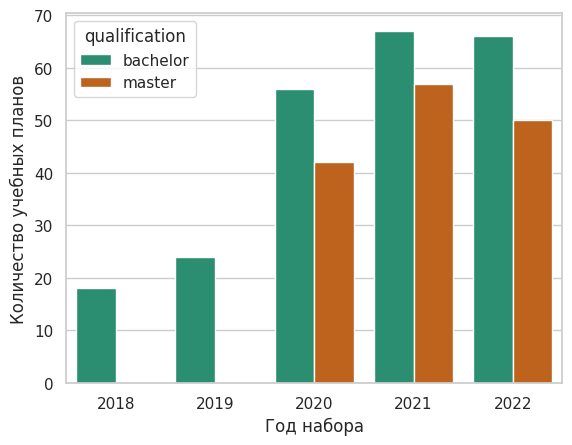

In [9]:
# количество учебных планов по годам и квалификациям
sns.barplot(data=df[["up_title", "qualification", "start_year"]].drop_duplicates().groupby(["start_year", "qualification"]).count().reset_index(), x="start_year", y="up_title", hue="qualification")
plt.ylabel("Количество учебных планов")
plt.xlabel("Год набора")
plt.show()

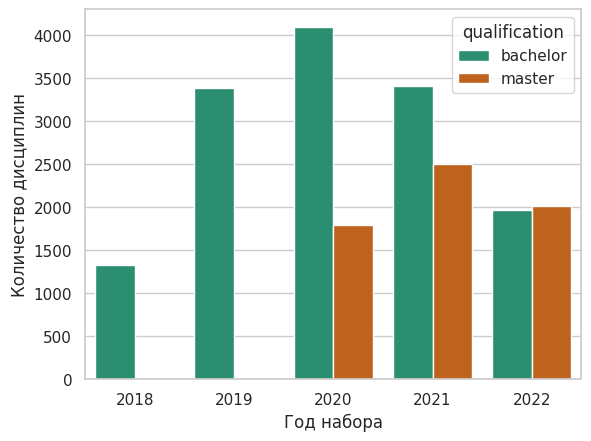

In [10]:
# количество дисциплин по годам и квалификациям
sns.barplot(data=df[["course_title", "qualification", "start_year"]].groupby(["start_year", "qualification"]).count().reset_index(), x="start_year", y="course_title", hue="qualification")
plt.ylabel("Количество дисциплин")
plt.xlabel("Год набора")
plt.show()

- Данные по магистратуре начали храниться с 2020 года, по бакалавриату – с 2018, поэтому графики выглядит именно так.
- Учебные планы могут существовать несколько лет с одним и тем же названием (как и дисциплины), поэтому в разрезе по годам уникальных записей больше, чем без него.

## Задача 1 – Предобработать description и contents
1. Выполнить предобработку текстовых данных. Минимально понадобятся следующие шаги предобработки:
  - приведение к одному регистру
  - токенизация
  - удаление пунктуации (можно оставить только буквенные символы в текстах)
  - лемматизация (можно использовать pymystem, он менее точный, чем pymorphy2, но работает в несколько раз быстрее)
2. Построить для дисциплины вектор на основе word2vec
3. Потестировать текстовые представления

Задач не много, но некоторые затратные по времени.

Для предобработки можно воспользовать материалами:
- https://colab.research.google.com/drive/1Lxe0_dPxF5_nNC1hnHTRc01rnMmUVCXa?usp=sharing
- https://colab.research.google.com/drive/16EFOsDbaTF2128kkVMqXxx2Xnb7Gr4mW?usp=share_link

### Предобработка текстовых данных

Проведите предобработку для столбца `contents`.

In [11]:
import nltk
import re
from nltk.corpus import stopwords
from pymystem3 import Mystem

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

m = Mystem()

stop_words = set(stopwords.words('russian'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [12]:
def preprocess_text(text: str) -> list[str]:
    # Приведение к нижнему регистру
    text = text.lower()

    # Удаление пунктуации, оставляем только буквенные символы
    text = re.sub(r'[^а-яА-ЯёЁа-яА-Я\s]', '', text)

    # Токенизация
    tokens = nltk.word_tokenize(text, language='russian')

    # Лемматизация
    lemmatized_tokens = m.lemmatize(' '.join(tokens))

    # Фильтруем стоп-слова
    lemmatized_tokens = [word for word in lemmatized_tokens if word not in stop_words and word.strip()]

    return lemmatized_tokens

In [13]:
# Применяем функцию к столбцу 'contents'
df['processed_contents'] = df['contents'].apply(preprocess_text)

In [14]:
# пример результата
df.sample(3, random_state=42)

,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,processed_contents
16112,17498,Создание технологического бизнеса,Цель курса - предоставить возможность магистра...,7198,Информационная безопасность / Information secu...,master,2022,Наукоемкое предпринимательство,Инновационный маркетинг. Корпоративные финансы...,"[инновационный, маркетинг, корпоративный, фина..."
2457,3002,Теория электрической связи,Программа составлена в соответствии с требован...,6989,Программирование в инфокоммуникационных системах,bachelor,2020,Модуль обязательных дисциплин,"Математические модели сигналов, помех и канало...","[математический, модель, сигнал, помеха, канал..."
1077,2736,Организация массовых мероприятий,Данная дисциплина учит планировать мероприятие...,6875,Управление технологическими инновациями,bachelor,2018,Модуль «Soft Skills»,Особенности организации массовых мероприятий.....,"[особенность, организация, массовый, мероприят..."


Проведите предобработку для столбца `description`.

In [15]:
# Применяем функцию к столбцу 'description'
df['processed_description'] = df['description'].apply(preprocess_text)

In [16]:
# пример результата
df.sample(3, random_state=42)

,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,processed_contents,processed_description
16112,17498,Создание технологического бизнеса,Цель курса - предоставить возможность магистра...,7198,Информационная безопасность / Information secu...,master,2022,Наукоемкое предпринимательство,Инновационный маркетинг. Корпоративные финансы...,"[инновационный, маркетинг, корпоративный, фина...","[цель, курс, предоставлять, возможность, магис..."
2457,3002,Теория электрической связи,Программа составлена в соответствии с требован...,6989,Программирование в инфокоммуникационных системах,bachelor,2020,Модуль обязательных дисциплин,"Математические модели сигналов, помех и канало...","[математический, модель, сигнал, помеха, канал...","[программа, составлять, соответствие, требован..."
1077,2736,Организация массовых мероприятий,Данная дисциплина учит планировать мероприятие...,6875,Управление технологическими инновациями,bachelor,2018,Модуль «Soft Skills»,Особенности организации массовых мероприятий.....,"[особенность, организация, массовый, мероприят...","[данный, дисциплина, учить, планировать, мероп..."


Данные минимально предобработаны. Можно переходить к векторизации. Рассмотрим два подхода:
- Word2Vec, обученный на предобработанных данных
- Tiny BERT – предобученная мини-версия мультиязычного BERT

### Кратко про языковые модели

Вне зависомости от того, большая модель или нет, данные, на которых она обучается и тестируется проходят одинаковые этапы предобработки.

Перед тем как начать обучение модели, необходимо подготовить текстовые данные. Этот процесс включает несколько этапов:

-	**Сбор данных.**

Модель обучается на большом корпусе текстов, который может включать книги, статьи, блоги, форумы и другие источники. Чем больше и разнообразнее данные, тем лучше модель сможет понять и воспроизвести язык.
-	**Токенизация.**

Процесс разбиения текста на отдельные элементы, называемые токенами. Токены могут представлять собой слова, части слов или даже отдельные символы. Например, фраза «Как дела?» может быть токенизирована как [«Как», «дела», «?»].
-	**Создание словарей.**

После токенизации формируется словарь, который сопоставляет с каждым токеном уникальный идентификатор. Этот словарь необходим для перевода текстовых данных в числовую форму, понятную модели.
-	**Преобразование текста в числовые векторы.**

Токены преобразуются в числовые векторы, которые будут использоваться в качестве входных данных для нейронной сети. Эти векторы могут быть статическими, как в Word2Vec, или динамическими, как в трансформерах.

---
Обучение языковой модели заключается в настройке её параметров на основе текстовых данных, чтобы она могла предсказывать следующее слово или генерировать осмысленные фразы.

-	**Forward propagation (прямой проход).**

На этом этапе данные проходят через слои нейронной сети, где каждое слово представляется в виде вектора. Эти векторы затем преобразуются в промежуточные состояния, которые несут информацию о контексте текста.
-	**Механизм внимания.**

В современных моделях, таких как трансформеры, используется механизм внимания, который позволяет модели выделять наиболее важные части текста, на которых нужно сосредоточиться при генерации или предсказании.
-	**Обратное распространение ошибки (Backpropagation).**

После того как модель сделала предсказание, она сравнивает его с реальными данными и вычисляет ошибку. Затем эта ошибка используется для корректировки параметров модели, чтобы улучшить точность предсказаний в будущем.
-	**Обучение на основе батчей.**

Данные разбиваются на небольшие группы — батчи, которые подаются модели для обучения. Этот метод позволяет эффективно использовать вычислительные ресурсы и ускорять процесс обучения.

Трансформеры
Современные языковые модели в большинстве основаны на архитектуре трансформеров, предложенной в 2017 году. Трансформеры решают многие проблемы, присущие RNN, и становятся доминирующим подходом в NLP.

-	**BERT (Bidirectional Encoder Representations from Transformers).**

Модель BERT использует двунаправленное обучение, что позволяет ей понимать контекст слова как слева, так и справа от него. Это делает BERT особенно мощным инструментом для задач, связанных с пониманием текста, таких как вопросо-ответные системы и анализ тональности.
-	**GPT (Generative Pre-Trained Transformer).**

Модель GPT, напротив, использует однонаправленное обучение, предсказывая следующее слово только на основе предыдущих слов. Эта модель, особенно в версиях GPT-2 и GPT-3, стала чрезвычайно популярной для генерации текста благодаря своей способности создавать связные и осмысленные сообщения, которые трудно отличить от текстов, написанных человеком.

### Векторизация word2vec

In [17]:
from gensim.models import Word2Vec
import gensim

In [18]:
# обучим на своих данных модель word2vec
# min_count – минимальная частота слова в корпусе
# vector_size – размер вектора для слова
# workers – количество потоков
# window – окно контекста, в которое попадает слово

w2v_model = Word2Vec(df["processed_contents"].to_list() + df["processed_description"].to_list(), min_count=1, vector_size=300, workers=2, window=10)

In [19]:
w2v_model_path = "w2v.bin" # будет удобно сохранить модель, если выполняете лабу не за один вечер
w2v_model.save(w2v_model_path)

In [20]:
# загрузка сохраненной модели
w2v_model = gensim.models.Word2Vec.load(w2v_model_path)

In [21]:
# так выглядит один вектор
print(w2v_model.wv.get_vector("обучение").shape)  # размер вектора
w2v_model.wv.get_vector("обучение")

(300,)


array([-1.16838485e-01,  1.86700153e+00, -7.83770144e-01,  4.93406153e+00,
       -1.53468466e+00, -1.65526494e-01,  2.45350051e+00,  1.77000749e+00,
       -7.89462984e-01, -2.27419758e+00, -1.34554625e+00,  2.66192746e+00,
        5.52143827e-02, -1.04446447e+00, -3.01276296e-01,  1.51341963e+00,
       -4.49139977e+00,  4.57685852e+00, -3.89715171e+00,  1.67797387e+00,
       -1.56921804e+00, -1.72645524e-01,  2.49385452e+00, -7.66474068e-01,
       -2.02135295e-01,  9.53898072e-01,  9.21949863e-01, -1.31686270e-01,
        1.96655917e+00, -8.27431619e-01, -5.40391207e-01, -2.80695391e+00,
        1.67121875e+00, -1.28363049e+00, -3.65753114e-01,  1.04018593e+00,
       -1.57036200e-01,  2.52068698e-01, -1.35801733e+00,  1.17548156e+00,
        2.02222323e+00,  1.00006950e+00,  3.61530244e-01, -1.91041613e+00,
        2.96475387e+00, -1.80219090e+00,  2.44057131e+00,  5.51122904e+00,
        2.87907553e+00, -4.67955971e+00, -9.84092772e-01, -1.08546531e+00,
       -7.83371568e-01,  

In [22]:
# слова, максимально близкие к "машинному обучению"
w2v_model.wv.most_similar(["обучение", "машинный"])

[('подкрепление', 0.5320070385932922),
 ('аномалия', 0.5311790704727173),
 ('коллаборативный', 0.524959146976471),
 ('учитель', 0.5216458439826965),
 ('векторизация', 0.4975650906562805),
 ('сигмоидальный', 0.4967207610607147),
 ('семантический', 0.48372918367385864),
 ('байесовский', 0.48231202363967896),
 ('нейронный', 0.47335928678512573),
 ('дегустатор', 0.4696144759654999)]

In [23]:
# слова, максимально близкие к "анализу данных"
w2v_model.wv.most_similar(["анализ", "данные"])

[('статистика', 0.4796013832092285),
 ('кластерный', 0.4744594991207123),
 ('питон', 0.4244370758533478),
 ('дескриптивный', 0.4185991585254669),
 ('перплексия', 0.4183679223060608),
 ('семантический', 0.40919265151023865),
 ('текстовый', 0.3861098289489746),
 ('нормализация', 0.3652849793434143),
 ('реляционный', 0.3643631935119629),
 ('данный', 0.36141660809516907)]

Семантически получились не идеальные, но в целом близкие списки. Это естественно, т.к. уникальных записей для обучения было передано около 2000.

Создадим два вектора для каждой дисциплины:
1. По данным содержания (`contents`)
2. По данным описание дисциплины (`description`)

Учитывайте, что должна быть возможность построить эмбеддинг для нового текста, даже если некоторые слова отсутствуют в исходной модели. При этом вектор не должен быть нулевым. Для этого напишите функцию `embed()`, в качестве агрументов принимающую список токенов текста и модель.

In [24]:
import numpy as np

In [25]:
def embed(tokens, w2v_model):
    vectors = []

    for token in tokens:
        if token in w2v_model.wv:
            vectors.append(w2v_model.wv[token])
        else:
            vectors.append(np.zeros(w2v_model.vector_size))

    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(w2v_model.vector_size)

# пример вектора
embed(df.iloc[0].processed_contents, w2v_model)

array([-0.8584645 , -0.05356132,  0.18801472,  0.2504933 ,  0.5324514 ,
        0.59305537, -0.05849904,  0.7530158 ,  0.8940218 ,  1.202421  ,
       -0.37234038, -0.1391561 ,  0.8117543 ,  0.3079378 ,  0.91317075,
       -0.7976633 , -0.43567315, -0.25441095,  0.19899283, -0.09683225,
        0.36866862, -0.51304865,  0.84260094,  0.13222346, -0.27430475,
        0.9114227 ,  0.8063339 ,  0.53127486,  0.01421545,  0.35006702,
       -0.04750325, -0.91765827, -0.30304807,  0.5349429 ,  0.32234183,
       -0.18458845, -0.344944  , -0.68242604, -0.67253333, -0.24946861,
       -1.1253202 , -0.2522731 ,  0.72700113,  0.19325674,  0.10673631,
       -0.6100082 , -0.28888994, -0.5262634 , -0.42086768, -0.7233461 ,
       -0.70713854,  0.85990983, -0.48321134, -0.60014796,  0.85171676,
       -0.67072415, -0.84966636, -0.34116375, -0.7166698 , -0.7864385 ,
        0.20411062, -1.1374698 ,  0.32183406, -0.40332344, -1.0402348 ,
        0.11229311, -0.25523022, -0.46454346, -0.30879262,  0.21

Теперь применим функцию `embed()` для формирования вектора для содержаний и кратких описаний в каждой записи.

In [26]:
df['embed_contents'] = df['processed_contents'].apply(lambda x: embed(x, w2v_model))
df['embed_description'] = df['processed_description'].apply(lambda x: embed(x, w2v_model))

# пример результата
df.sample(3, random_state=42)

,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,processed_contents,processed_description,embed_contents,embed_description
16112,17498,Создание технологического бизнеса,Цель курса - предоставить возможность магистра...,7198,Информационная безопасность / Information secu...,master,2022,Наукоемкое предпринимательство,Инновационный маркетинг. Корпоративные финансы...,"[инновационный, маркетинг, корпоративный, фина...","[цель, курс, предоставлять, возможность, магис...","[-0.40107477, 0.36341298, 0.75880516, -0.03928...","[0.17025161, -0.36157763, 1.1247432, 0.8575981..."
2457,3002,Теория электрической связи,Программа составлена в соответствии с требован...,6989,Программирование в инфокоммуникационных системах,bachelor,2020,Модуль обязательных дисциплин,"Математические модели сигналов, помех и канало...","[математический, модель, сигнал, помеха, канал...","[программа, составлять, соответствие, требован...","[-0.5089721, 0.21258375, -0.57037395, -0.33247...","[-0.14916195, 0.53515416, 0.35941032, 0.143410..."
1077,2736,Организация массовых мероприятий,Данная дисциплина учит планировать мероприятие...,6875,Управление технологическими инновациями,bachelor,2018,Модуль «Soft Skills»,Особенности организации массовых мероприятий.....,"[особенность, организация, массовый, мероприят...","[данный, дисциплина, учить, планировать, мероп...","[-0.23191147, -0.86057174, 1.3109405, 0.575381...","[0.46024913, -0.7375609, 0.732215, 0.6329133, ..."


Оценим, насколько семантически близки краткие описания дисциплин и темы в содержании. Для оценки воспользуемся косинусным сходством.

$$K(X, Y) = \frac{X \cdot Y} {||X||*||Y||}$$

В `sklearn` функция для расчета косинусного сходства генерирует матрицу результатов, мы будем сравнивать всего два вектора, поэтому напишем свою обертку для функции из `sklearn` так, чтобы она возвращала одно числовое значение, а не матрицу.

In [27]:
from sklearn.metrics.pairwise import cosine_similarity as cs

def cosine_similarity(vec1, vec2):
    return cs([vec1], [vec2])[0][0]

In [28]:
# посчитаем косинусное сходство
df["desc_cont_sim"] = df.apply(lambda x: cosine_similarity(x["embed_contents"], x["embed_description"]), axis=1)

Оценим по графику распределение сходств для всех дисциплин. Должен получиться график, похожий на гистограмму ниже. Пунктиром обозначено медианное значение.

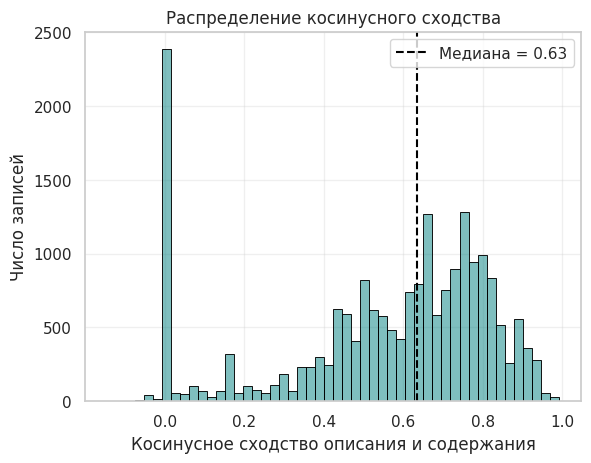

In [29]:
sns.histplot(df["desc_cont_sim"], bins=50, color='teal', alpha=0.5, edgecolor='black')
plt.axvline(df["desc_cont_sim"].median(), color='black', linestyle='--', label=f"Медиана = {df['desc_cont_sim'].median():.2f}")

plt.title("Распределение косинусного сходства")
plt.xlabel("Косинусное сходство описания и содержания")
plt.ylabel("Число записей")
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

### Векторизация Tiny BERT

В качестве предобученной модели воспользуемся Tiny BERT – https://huggingface.co/sergeyzh/rubert-tiny-turbo

Она априори менее точная, чем базовый BERT, но строит эмбеддинги в разы быстрее.

In [30]:
# загружаем модель из библиотеки huggingface

from sentence_transformers import SentenceTransformer

bert_model = SentenceTransformer('sergeyzh/rubert-tiny-turbo')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/431k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/712 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/117M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.41M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/732 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/196 [00:00<?, ?B/s]

> Если вы выполняете эту лабораторную локально, то возможны конфликты версии `sentence_transformers` и `tensorflow`, обычно решающиеся даунгрейдом `tensorflow`.

Прежде чем формировать эмбеддинги, объединим список токенов в строку.

In [31]:
df['processed_contents_text'] = df['processed_contents'].apply(lambda x: ' '.join(x))
df['processed_description_text'] = df['processed_description'].apply(lambda x: ' '.join(x))

# пример результата преобразования
df.sample(3, random_state=42)

,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,processed_contents,processed_description,embed_contents,embed_description,desc_cont_sim,processed_contents_text,processed_description_text
16112,17498,Создание технологического бизнеса,Цель курса - предоставить возможность магистра...,7198,Информационная безопасность / Information secu...,master,2022,Наукоемкое предпринимательство,Инновационный маркетинг. Корпоративные финансы...,"[инновационный, маркетинг, корпоративный, фина...","[цель, курс, предоставлять, возможность, магис...","[-0.40107477, 0.36341298, 0.75880516, -0.03928...","[0.17025161, -0.36157763, 1.1247432, 0.8575981...",0.437570,инновационный маркетинг корпоративный финансы ...,цель курс предоставлять возможность магистрант...
2457,3002,Теория электрической связи,Программа составлена в соответствии с требован...,6989,Программирование в инфокоммуникационных системах,bachelor,2020,Модуль обязательных дисциплин,"Математические модели сигналов, помех и канало...","[математический, модель, сигнал, помеха, канал...","[программа, составлять, соответствие, требован...","[-0.5089721, 0.21258375, -0.57037395, -0.33247...","[-0.14916195, 0.53515416, 0.35941032, 0.143410...",0.069960,математический модель сигнал помеха канал связ...,программа составлять соответствие требование о...
1077,2736,Организация массовых мероприятий,Данная дисциплина учит планировать мероприятие...,6875,Управление технологическими инновациями,bachelor,2018,Модуль «Soft Skills»,Особенности организации массовых мероприятий.....,"[особенность, организация, массовый, мероприят...","[данный, дисциплина, учить, планировать, мероп...","[-0.23191147, -0.86057174, 1.3109405, 0.575381...","[0.46024913, -0.7375609, 0.732215, 0.6329133, ...",0.648461,особенность организация массовый мероприятие п...,данный дисциплина учить планировать мероприяти...


Чтобы не генерировать несколько раз одинаковые векторы (в данных много неуникальных описаний и содеражний), оставим только уникальные, а затем присоединим их в исходную таблицу. Уникальных записей в разрезе описания и содержания около 2500.

>`tqdm.auto` позволяет в удобном формате добавлять прогресс-бар к некоторым методам `pandas` – например, `apply`, и получать метод `progress_apply`.

In [32]:
from tqdm.auto import tqdm
tqdm.pandas()

unique_content = df[['processed_contents_text', 'processed_description_text']].drop_duplicates()

unique_content['bert_contents'] = unique_content['processed_contents_text'].progress_apply(lambda x: bert_model.encode(x))
unique_content['bert_description'] = unique_content['processed_description_text'].progress_apply(lambda x: bert_model.encode(x))

  0%|          | 0/2286 [00:00<?, ?it/s]

  0%|          | 0/2286 [00:00<?, ?it/s]

Теперь присоедините полученную таблицу в исходный датафрейм.

In [33]:
df = df.merge(unique_content, on=['processed_contents_text', 'processed_description_text'], how='left')

# пример результата объединения
print(df.shape)
df.sample(3, random_state=42)

(20502, 18)


,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,processed_contents,processed_description,embed_contents,embed_description,desc_cont_sim,processed_contents_text,processed_description_text,bert_contents,bert_description
16112,17498,Создание технологического бизнеса,Цель курса - предоставить возможность магистра...,7198,Информационная безопасность / Information secu...,master,2022,Наукоемкое предпринимательство,Инновационный маркетинг. Корпоративные финансы...,"[инновационный, маркетинг, корпоративный, фина...","[цель, курс, предоставлять, возможность, магис...","[-0.40107477, 0.36341298, 0.75880516, -0.03928...","[0.17025161, -0.36157763, 1.1247432, 0.8575981...",0.437570,инновационный маркетинг корпоративный финансы ...,цель курс предоставлять возможность магистрант...,"[-0.01884348, -0.03382881, 0.019070776, -0.012...","[0.018506978, -0.03154075, 0.028918136, 0.0206..."
2457,3002,Теория электрической связи,Программа составлена в соответствии с требован...,6989,Программирование в инфокоммуникационных системах,bachelor,2020,Модуль обязательных дисциплин,"Математические модели сигналов, помех и канало...","[математический, модель, сигнал, помеха, канал...","[программа, составлять, соответствие, требован...","[-0.5089721, 0.21258375, -0.57037395, -0.33247...","[-0.14916195, 0.53515416, 0.35941032, 0.143410...",0.069960,математический модель сигнал помеха канал связ...,программа составлять соответствие требование о...,"[-0.014049813, 0.0051561347, 0.058621705, -0.0...","[0.03028773, -0.013735164, 0.018652005, -0.010..."
1077,2736,Организация массовых мероприятий,Данная дисциплина учит планировать мероприятие...,6875,Управление технологическими инновациями,bachelor,2018,Модуль «Soft Skills»,Особенности организации массовых мероприятий.....,"[особенность, организация, массовый, мероприят...","[данный, дисциплина, учить, планировать, мероп...","[-0.23191147, -0.86057174, 1.3109405, 0.575381...","[0.46024913, -0.7375609, 0.732215, 0.6329133, ...",0.648461,особенность организация массовый мероприятие п...,данный дисциплина учить планировать мероприяти...,"[0.017201137, -0.004298017, 0.012148312, -0.02...","[0.033387527, -0.001978374, -0.0038183925, 0.0..."


In [34]:
# размер вектора Tiny BERT – 312, что близко к размеру векторов w2v
df.bert_contents[0].shape

(312,)

Повторим эксперимент из предыдущего раздела – оценим, насколько схожи векторы описания и содержания для одной дисциплины, сгенерированные BERT.

In [35]:
df['bert_desc_cont_sim'] = df.apply(lambda x: cosine_similarity(x["bert_contents"], x["bert_description"]), axis=1)

Постройте график. Вероятно, он будет похож на тот, что ниже.

Здесь снова пунктиром обозначена медиана.

In [36]:
# ваш код здесь

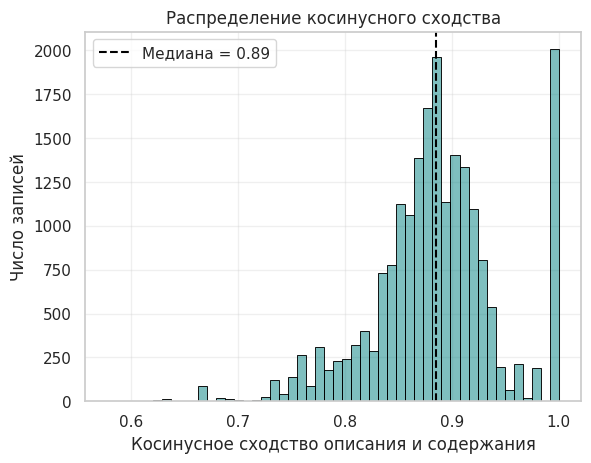

In [37]:
sns.histplot(df["bert_desc_cont_sim"], bins=50, color='teal', alpha=0.5, edgecolor='black')
plt.axvline(df["bert_desc_cont_sim"].median(), color='black', linestyle='--', label=f"Медиана = {df['bert_desc_cont_sim'].median():.2f}")

plt.title("Распределение косинусного сходства")
plt.xlabel("Косинусное сходство описания и содержания")
plt.ylabel("Число записей")
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

Теперь сравните распределения сходств, полученных при использовании разных подходов к векторизации.

В результате должно получиться нечто похожее на гистограмму ниже. По ней видно, что вектора Tiny BERT дают более узкий диапазон сходств. И более высокие значения. Это можно объяснить тем, что:
- модель обучалась на более широком контексте и не улавливает тонкостей разных дисциплин
- относительно стандартного BERT качество модели сильно ниже (его можно поизучать по ссылке в начале раздела)

In [38]:
# ваш код здесь

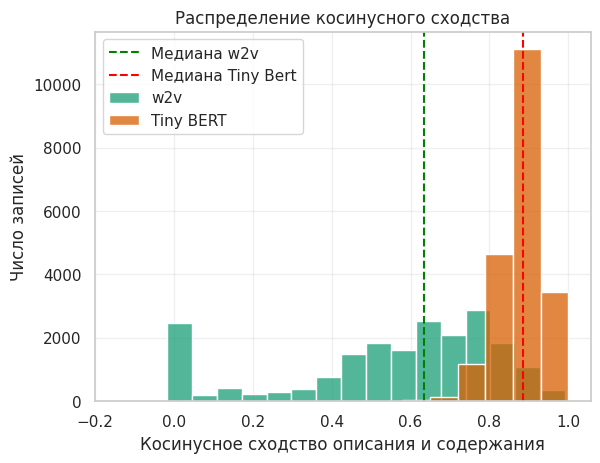

In [39]:
sns.histplot(data = df['desc_cont_sim'], bins=18, label='w2v')
sns.histplot(data = df['bert_desc_cont_sim'], bins=6, label='Tiny BERT')
w2v_xmedian = np.median(df['desc_cont_sim'])
bert_xmedian = np.median(df['bert_desc_cont_sim'])
plt.axvline(w2v_xmedian, color='green', linestyle='--', label='Медиана w2v')
plt.axvline(bert_xmedian, color='red', linestyle='--', label='Медиана Tiny Bert')

plt.title("Распределение косинусного сходства")
plt.xlabel("Косинусное сходство описания и содержания")
plt.ylabel("Число записей")
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

## Задача 2 – Сгенерировать description и contents

Задача 2 – исследовательская. Надо проверить, как с работой преподавателя справится большая языковая модель. В исходных данных расположены описания и темы из содержания, написанные реальными людьми. Теперь используем LLM для той же задачи. Также рассмотрим, как разные техники промпт-инжиниринга будут влиять на результат.

### Техники промпт-инжиниринга

Под техникой промпт-инжиниринга (или промптинга) понимается практика разработки и оптимизации промптов (запросов, подсказок) к модели, которые помогут получить максимально близкий к ожидаемому ответ и эффективно взаимодействовать с языковой моделью. Это ключевой элемент в управлении работой и поведением LLM.


Наиболее популярными являются следующие техники:
1. **Zero-shot** (Обучение без примеров) – модель применяет общие знания и правила для решения новых задач.
2. **Few-shot** (Обучение на нескольких примерах) – модель адаптируется к новым задачам, используя небольшой набор примеров.
3. **Chain-of-thought** (Цепочка рассуждений) – модель генерирует пошаговое рассуждение для решения задачи, что помогает в понимании сложных задач и улучшает точность ответов.
4. **Tree of thoughts** (Дерево рассуждений) – подход, при котором рассматриваются различные варианты решений или идей, ветвящиеся от основной мысли.

В этой работе воспользуемся первыми двумя подходами.

В колабе слишком мало ресурсов (если пользоваться бесплатной версией), чтобы хотя бы запустить какую-нибудь интересную современную модель через модуль `transformers`, и тем более ресурсов не хватит для дообучения. Поэтому для тестирования воспользуемся API/serverless API.

Тестировать запросы будем к LLM mistral-nemo-instruct-2407 – https://huggingface.co/mistralai/Mistral-Nemo-Instruct-2407

Это дообученная instruct-версия модели mistral-nemo-base-2407 (12В). Модели категории Instruct способны генерировать ответ, следуя заданному им шаблону поведения.

Обе версии (base и instruct) мультиязычные и выпущены MistralAI и NVIDIA в июле 2024.

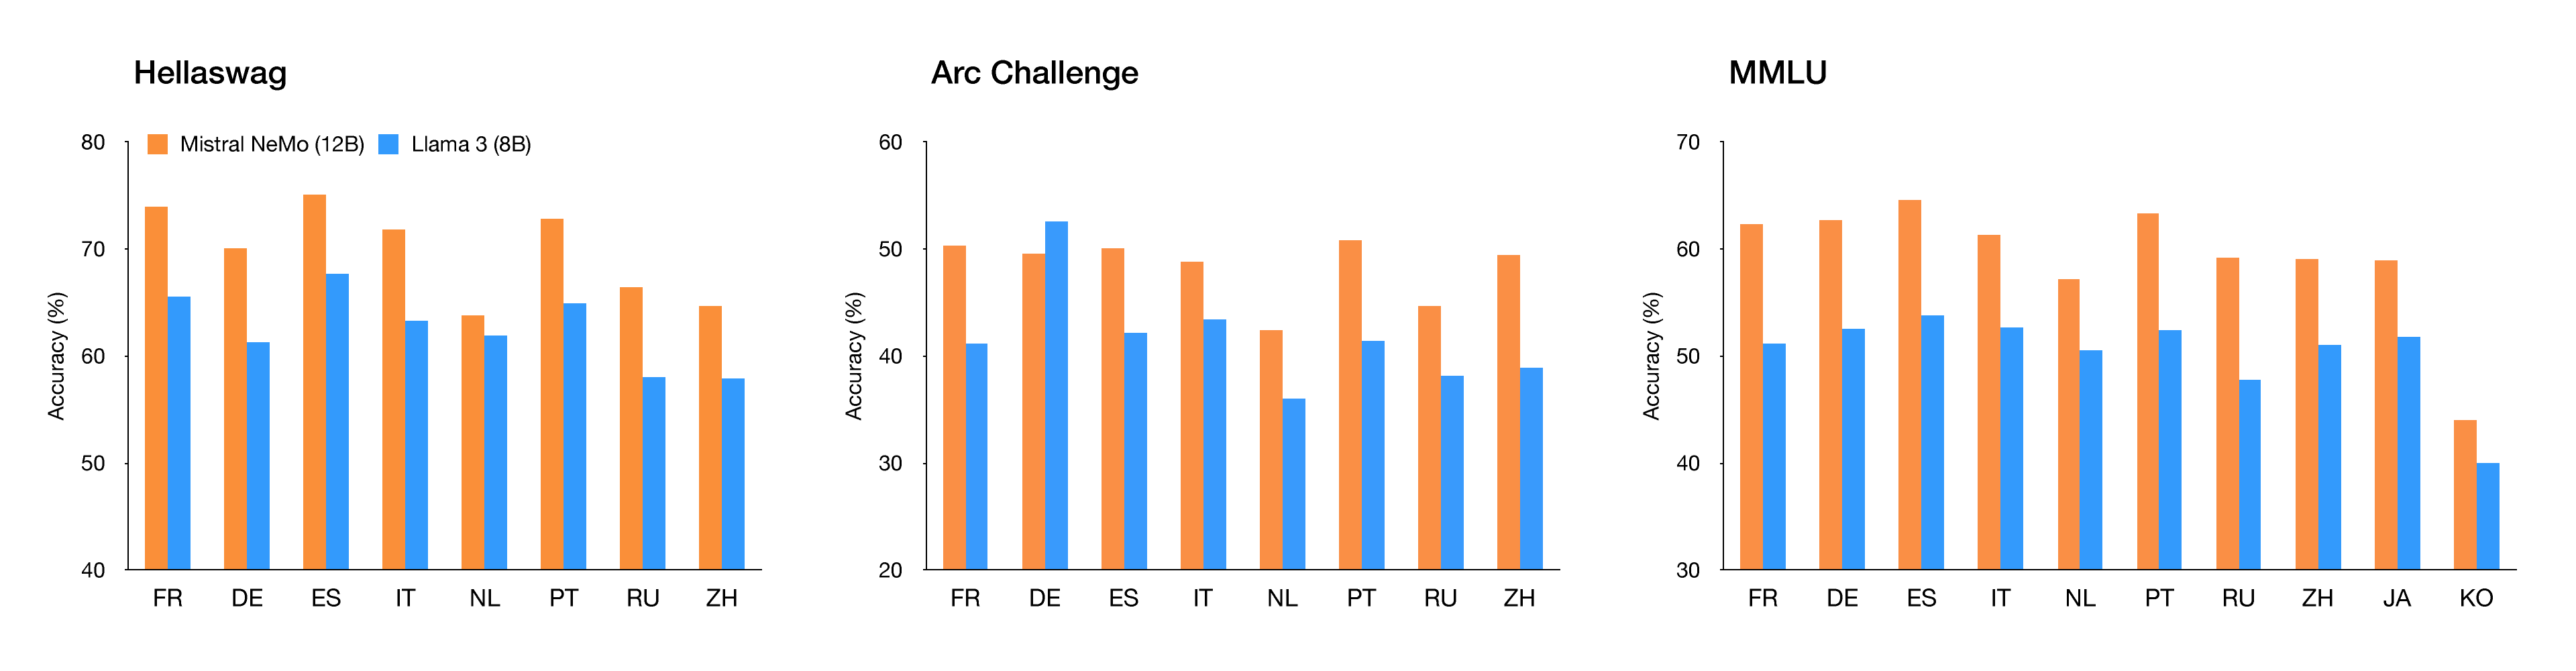

#### zero-shot

Техника промпт-инжиниринга, в которой мы, не давая модели никакой вспомогательной информации, ожидаем от нее ответа на запрос (промпт) в свободной форме.

In [58]:
from google.colab import userdata

In [59]:
from huggingface_hub import InferenceClient

client = InferenceClient(api_key=userdata.get('HUGGING_FACE_API_KEY'))  # ваш токен с  HuggingFace

Базово запустим модель через serverless API, предоставляемый HuggingFace. Это самый простой способо интегрировать модель в колаб. Для использования в реальных приложениях он не подойдет.

In [60]:
messages = [
	{
		"role": "user",
		"content": """Ты – преподаватель в университете.
                  Перечисли темы и разделы для дисциплины 'Язык Python для анализа данных'.
                  Разделов должно быть не более 8.
									Отвечай на русском языке."""
	}
]

completion = client.chat.completions.create(
    model="mistralai/Mistral-Nemo-Instruct-2407",
	  messages=messages,
	  max_tokens=500
)

print(completion.choices[0].message.content)

Хорошо, вот список тем и разделов, которые я мог бы включить в дисциплину "Язык Python для анализа данных":

1. Введение в Python и его использование для анализа данных
2. Основы программирования на Python: типы данных, переменные, операторы, selección estructura
3. Функции и модули в Python
4..UUID  - чтобы работать с всхльным слаем при ошибки
5. визначення чемных чисел
6. Работа с файлами и данными в Python
7. Библиотека NumPy для численных операций и работы с массивами
8. Библиотека Pandas для работы с табличными данными и анализом данных.


Можно получить что-то адекватное, а можно – что-то такое🤣

>**Текст промпта имеет значение!**

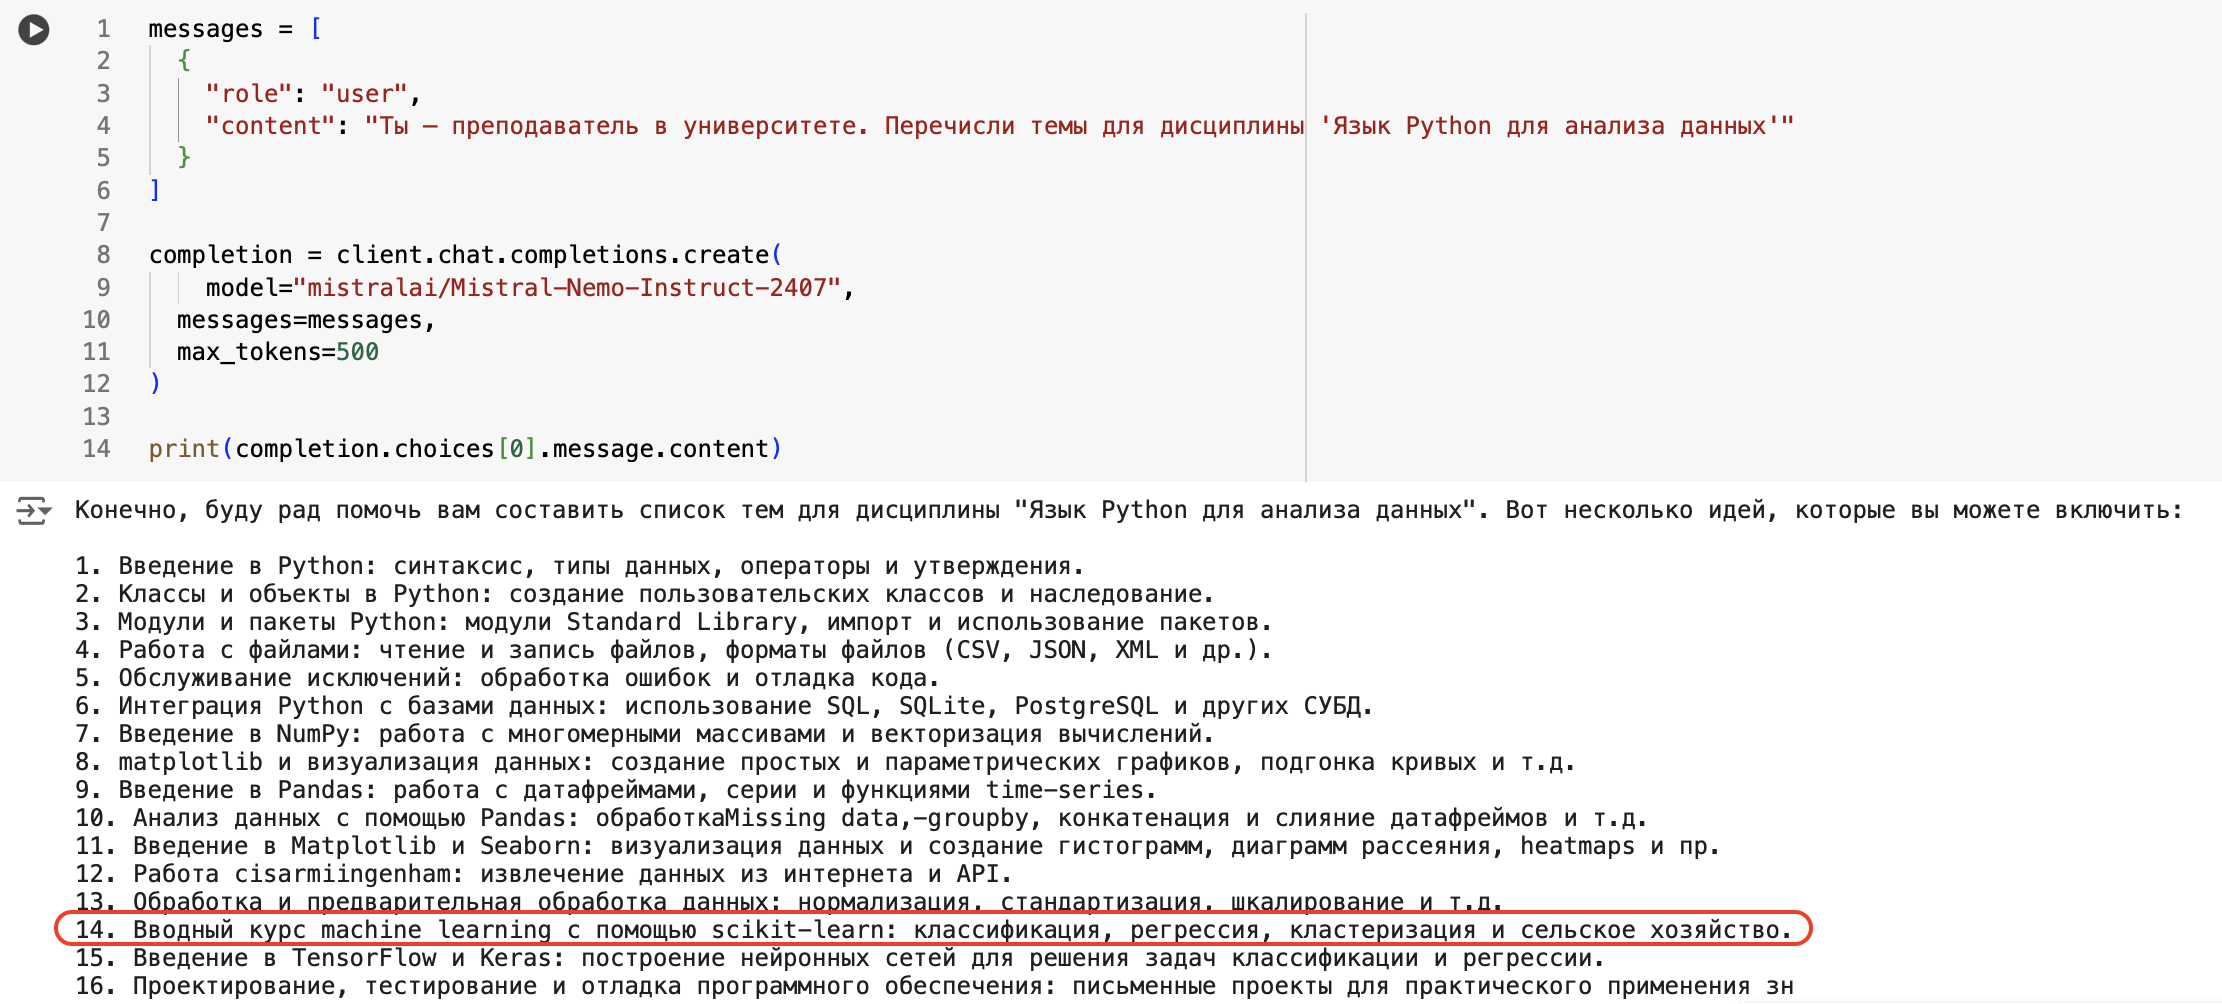

Но параметры API-запросов можно настраивать – https://huggingface.co/docs/api-inference/tasks/chat-completion

Наиболее ценные из них, сокращающие число галлюцинаций модели:
- temperature (температура): варьируется от 0 до 2 – чем выше, тем выше свобода модели в самовыражении и тем случайнее результат. До 0.5 считается низкой, но хорошо поэкспериментировать, чтобы подобрать наиболее адекватный для своей задачи результат.
- top_p – задает планку (долю), по которой отсекаются наименее релевантные ответы для вопроса, 0.1 означает, что для формирования ответа берутся 10% наиболее значимых токенов. Рекомендуется настраивать либо температуру, либо вероятность.

Поработаем с температурой. В качестве примера сгенерируем содержание дисциплины "Язык Python для анализа данных" с температурой от 0 до 2 с шагом 0.1.

In [61]:
import numpy as np

messages = [
	{
		"role": "user",
		"content": "Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины 'Язык Python для анализа данных'. Разделов должно быть не более 8."
	}
]

temperatures = np.arange(0,2,0.1)

for temp in temperatures:
    print(f"\n{'*'*20} temperature = {temp} {'*'*20}\n")

    completion = client.chat.completions.create(
        model="mistralai/Mistral-Nemo-Instruct-2407",
        messages=messages,
        max_tokens=500,
        temperature=temp
    )

    print(completion.choices[0].message.content)



******************** temperature = 0.0 ********************

1. Введение в Python: основные понятия, синтаксис, типы данных, переменные, операторы, циклы, функции.
2. Модули и пакеты: импорт модулей, работа с пакетами, виртуальные окружения.
3. Работа с файлами: чтение и запись файлов, работа с директориями, исключения при работе с файлами.
4. Коллекции данных: списки, кортежи, словари, множества, работа с коллекциями.
5. Функции высшего порядка: map, filter, reduce, lambda-функции, декораторы.
6. Объектно-ориентированное программирование: классы, объекты, наследование, полиморфизм, инкапсуляция.
7. Работа с датами и временем: модуль datetime, форматирование дат и времени.
8. Введение в NumPy и Pandas: работа с многомерными массивами, сериалами, датафреймами, визуализация данных.

******************** temperature = 0.1 ********************

1. Введение в Python: основные понятия, синтаксис, типы данных, переменные, операторы, циклы, функции.
2. Модули и пакеты: импорт модулей, работа 

Вывод: если температуру выкрутить на максимум, концентрация бреда зашкаливает, перемешиваются языки, генерируютя несуществующие слова; а если занулить, то ответ получается похожий на правду, но очень ограниченный и сухой.
>**Нужно искать такое значение температуры, при котором будет соблюдаться баланс между честностью и свободой творчества.**

В примере выше наиболее интересные результаты получились при температуре от 0.3 до 0.7. Результат на 0.7 наиболее творческий и обширный. В таком примере стоит потестировать несколько температур и повалидировать их генерации.

Попробуем еще пару примеров с другими дисциплинами.

In [62]:
import numpy as np

courses = ["Машинное обучение",
           "Современные инструменты для анализа данных",
           "Методы визуализации данных"]

messages = [
	[{
		"role": "user",
		"content": "Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины {}. Разделов должно быть не более 8.".format(course)
	}] for course in courses
]

print(messages)

# перебирать температуры выше 1 не будем, там все плохо
temperatures = np.arange(0.3,1,0.1)


for i, message in enumerate(messages):

    for temp in temperatures:
        print(f"\n{'*'*20} {courses[i]}: temperature = {temp} {'*'*20}\n")

        completion = client.chat.completions.create(
            model="mistralai/Mistral-Nemo-Instruct-2407",
            messages=message,
            max_tokens=500,
            temperature=temp
        )

        print(completion.choices[0].message.content)

[[{'role': 'user', 'content': 'Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины Машинное обучение. Разделов должно быть не более 8.'}], [{'role': 'user', 'content': 'Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины Современные инструменты для анализа данных. Разделов должно быть не более 8.'}], [{'role': 'user', 'content': 'Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины Методы визуализации данных. Разделов должно быть не более 8.'}]]

******************** Машинное обучение: temperature = 0.3 ********************

1. Введение в машинное обучение
2. Математические основы машинного обучения
3. Алгоритмы обучения с учителем
4. Алгоритмы обучения без учителя
5. Выбор и оценка моделей
6. Нейронные сети и глубокое обучение
7. Применение машинного обучения в различных областях
8. Этика и этические аспекты машинного обучения

******************** Машинное обучение: temperature = 0.4 ********************

1. Введение

Здесь наиболее интересные ответы получаются при температуре 0.5–0.7. 0.7 ни в одном примере пока не ушли в откровенные галлюцинации.

Теперь сгенерируем содержание для 100 случайных дисциплин. Не будем брать все с целью экономии времени. Если есть время и желание, можно для всех 1757.

In [63]:
ud = df[["course_title"]].drop_duplicates().sample(100, random_state=42)
ud.shape

(100, 1)

Напишите функцию `mistral_zero_shot()`, которая принимает на вход название дисциплины, объект клиента и значение температуры, а возвращает содержание дисциплины.

Альтернативно промпт можно тоже сделать параметром.

In [64]:
def mistral_zero_shot(course, cli, temp, prompt):
    message = [
      {
        "role": "user",
        "content": prompt,
      }
    ]

    completion = cli.chat.completions.create(
            model="mistralai/Mistral-Nemo-Instruct-2407",
            messages=message,
            max_tokens=500,
            temperature=temp
    )

    return completion.choices[0].message.content

Добавьте столбец со сгенерированным содержанием в датафрейм.

In [65]:
prompt = "Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины \"{}\". Разделов должно быть не более 8."
ud["zero_shot_contents"] = ud["course_title"].progress_apply(lambda course: mistral_zero_shot(course, client, 0.7, prompt.format(course)))

  0%|          | 0/100 [00:00<?, ?it/s]

In [94]:
ud_df = df.merge(ud[['course_title', 'zero_shot_contents']], on='course_title', how='inner')

# пример результата после добавления столбца с генерацией
print(ud_df.shape)
ud_df.sample(3, random_state=42)

(1046, 20)


,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,processed_contents,processed_description,embed_contents,embed_description,desc_cont_sim,processed_contents_text,processed_description_text,bert_contents,bert_description,bert_desc_cont_sim,zero_shot_contents
773,15443,Моделирование оптических процессов,Что такое фотоника? На наш взгляд это очень пе...,6909,Бизнес-информатика,bachelor,2020,ОГНП 7: Фотоника,Введение в методы численной электродинамики. О...,"[введение, метод, численный, электродинамика, ...","[фотоника, наш, взгляд, это, очень, перспектив...","[-0.3259147, 0.84914917, -0.12819101, -0.21436...","[0.14377132, 0.36896816, -0.088708684, 0.26280...",0.284737,введение метод численный электродинамика основ...,фотоника наш взгляд это очень перспективный об...,"[-0.017257802, -0.005506248, 0.0431188, -0.018...","[0.008544883, -0.013509471, 0.024948549, -0.01...",0.897840,1. Введение в моделирование оптических процесс...
280,7593,Техническая термодинамика и теплопередача,"Представлены начала термодинамики, методы расч...",7311,Низкотемпературная техника и энергетика,bachelor,2019,Модуль обязательных дисциплин,Подобие и моделирование процессов конвективног...,"[подобие, моделирование, процесс, конвективный...","[представлять, начало, термодинамика, метод, р...","[0.45941254, 0.73544085, 0.33546203, -0.767792...","[0.6932598, 0.8760386, 0.34538105, -0.33893323...",0.901230,подобие моделирование процесс конвективный теп...,представлять начало термодинамика метод расчет...,"[0.0047562807, 0.010405966, 0.022855595, 0.000...","[0.0027674034, -0.010737589, 0.019425986, -0.0...",0.935841,1. Введение в техническую термодинамику и осно...
629,14936,Культурные подходы к цифровым практикам,Основная задача данного курса - предложить ра...,6987,Инфохимия / Infochemistry,master,2020,Факультативные дисциплины,"Библиотеки, архивы, энциклопедии, история big...","[библиотека, архив, энциклопедия, история, игр...","[основной, задача, данный, курс, предлагать, р...","[-0.20870276, 0.2547111, -0.1759304, 0.0213794...","[0.16978104, -0.07928847, 0.18107586, 0.311427...",0.571795,библиотека архив энциклопедия история игра мул...,основной задача данный курс предлагать различн...,"[0.036509857, -0.01968107, 0.06787346, 7.72789...","[-0.023287887, -0.002322669, 0.0868273, -0.000...",0.890441,1. Введение в культурные подходы к цифровым пр...


Векторизуйте сгенерированное содержание с помощью обоих векторайзеров из предыдущего задания.

In [96]:
ud_df['zero_shot_embed_contents'] = ud_df['zero_shot_contents'].apply(lambda x: embed(x, w2v_model))
ud_df['zero_shot_bert_contents'] = ud_df['zero_shot_contents'].apply(lambda x: bert_model.encode(x))

In [97]:
# пример результата обработки
ud_df.sample(3, random_state=42)

,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,processed_contents,...,embed_description,desc_cont_sim,processed_contents_text,processed_description_text,bert_contents,bert_description,bert_desc_cont_sim,zero_shot_contents,zero_shot_embed_contents,zero_shot_bert_contents
773,15443,Моделирование оптических процессов,Что такое фотоника? На наш взгляд это очень пе...,6909,Бизнес-информатика,bachelor,2020,ОГНП 7: Фотоника,Введение в методы численной электродинамики. О...,"[введение, метод, численный, электродинамика, ...",...,"[0.14377132, 0.36896816, -0.088708684, 0.26280...",0.284737,введение метод численный электродинамика основ...,фотоника наш взгляд это очень перспективный об...,"[-0.017257802, -0.005506248, 0.0431188, -0.018...","[0.008544883, -0.013509471, 0.024948549, -0.01...",0.897840,1. Введение в моделирование оптических процесс...,"[-0.3239396360658464, 0.015398795574548698, -0...","[0.012035356, 0.026579993, -0.01010953, -0.022..."
280,7593,Техническая термодинамика и теплопередача,"Представлены начала термодинамики, методы расч...",7311,Низкотемпературная техника и энергетика,bachelor,2019,Модуль обязательных дисциплин,Подобие и моделирование процессов конвективног...,"[подобие, моделирование, процесс, конвективный...",...,"[0.6932598, 0.8760386, 0.34538105, -0.33893323...",0.901230,подобие моделирование процесс конвективный теп...,представлять начало термодинамика метод расчет...,"[0.0047562807, 0.010405966, 0.022855595, 0.000...","[0.0027674034, -0.010737589, 0.019425986, -0.0...",0.935841,1. Введение в техническую термодинамику и осно...,"[-0.34153428764653143, 0.003621533189144292, -...","[0.023301844, -0.0024123508, -0.0058031487, -0..."
629,14936,Культурные подходы к цифровым практикам,Основная задача данного курса - предложить ра...,6987,Инфохимия / Infochemistry,master,2020,Факультативные дисциплины,"Библиотеки, архивы, энциклопедии, история big...","[библиотека, архив, энциклопедия, история, игр...",...,"[0.16978104, -0.07928847, 0.18107586, 0.311427...",0.571795,библиотека архив энциклопедия история игра мул...,основной задача данный курс предлагать различн...,"[0.036509857, -0.01968107, 0.06787346, 7.72789...","[-0.023287887, -0.002322669, 0.0868273, -0.000...",0.890441,1. Введение в культурные подходы к цифровым пр...,"[-0.2955086183082312, 0.0009245519029112378, -...","[0.036967784, 0.0038710928, 0.07892606, 0.0360..."


Посчитайте косинусное сходство вектора исходных содержаний и сгенерированных для обоих векторайзеров.

In [98]:
ud_df['zero_shot_cont_sim'] = ud_df.apply(lambda x: cosine_similarity(x["zero_shot_embed_contents"], x["embed_contents"]), axis=1)
ud_df['zero_shot_bert_cont_sim'] = ud_df.apply(lambda x: cosine_similarity(x["zero_shot_bert_contents"], x["bert_contents"]), axis=1)

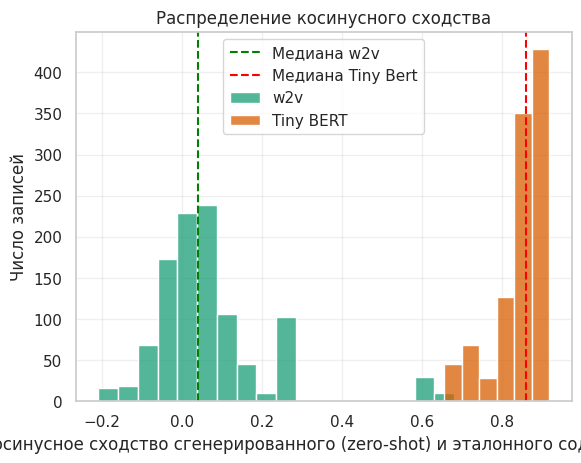

In [99]:
sns.histplot(data = ud_df['zero_shot_cont_sim'], bins=18, label='w2v')
sns.histplot(data = ud_df['zero_shot_bert_cont_sim'], bins=6, label='Tiny BERT')
w2v_xmedian = np.median(ud_df['zero_shot_cont_sim'])
bert_xmedian = np.median(ud_df['zero_shot_bert_cont_sim'])
plt.axvline(w2v_xmedian, color='green', linestyle='--', label='Медиана w2v')
plt.axvline(bert_xmedian, color='red', linestyle='--', label='Медиана Tiny Bert')

plt.title("Распределение косинусного сходства")
plt.xlabel("Косинусное сходство сгенерированного (zero-shot) и эталонного содержания")
plt.ylabel("Число записей")
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()


Повторите этот пайплайн для генерации краткого описания дисциплины (`description`) в технике `one-shot`.

In [71]:
prompt = "Представь, что ты преподаватель в университете. Создай короткое описание для дисциплины \"{}\"."

ud["zero_shot_description"] = ud["course_title"].progress_apply(lambda course: mistral_zero_shot(course, client, 0.7, prompt.format(course)))

  0%|          | 0/100 [00:00<?, ?it/s]

In [100]:
ud_df = ud_df.merge(ud[['course_title', 'zero_shot_description']], on='course_title', how='inner')

# пример результата после добавления столбца с генерацией
print(ud_df.shape)
ud_df.sample(3, random_state=42)

(1046, 25)


,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,processed_contents,...,processed_description_text,bert_contents,bert_description,bert_desc_cont_sim,zero_shot_contents,zero_shot_embed_contents,zero_shot_bert_contents,zero_shot_cont_sim,zero_shot_bert_cont_sim,zero_shot_description
773,15443,Моделирование оптических процессов,Что такое фотоника? На наш взгляд это очень пе...,6909,Бизнес-информатика,bachelor,2020,ОГНП 7: Фотоника,Введение в методы численной электродинамики. О...,"[введение, метод, численный, электродинамика, ...",...,фотоника наш взгляд это очень перспективный об...,"[-0.017257802, -0.005506248, 0.0431188, -0.018...","[0.008544883, -0.013509471, 0.024948549, -0.01...",0.897840,1. Введение в моделирование оптических процесс...,"[-0.3239396360658464, 0.015398795574548698, -0...","[0.012035356, 0.026579993, -0.01010953, -0.022...",0.039844,0.858912,"Дисциплина ""Моделирование оптических процессов..."
280,7593,Техническая термодинамика и теплопередача,"Представлены начала термодинамики, методы расч...",7311,Низкотемпературная техника и энергетика,bachelor,2019,Модуль обязательных дисциплин,Подобие и моделирование процессов конвективног...,"[подобие, моделирование, процесс, конвективный...",...,представлять начало термодинамика метод расчет...,"[0.0047562807, 0.010405966, 0.022855595, 0.000...","[0.0027674034, -0.010737589, 0.019425986, -0.0...",0.935841,1. Введение в техническую термодинамику и осно...,"[-0.34153428764653143, 0.003621533189144292, -...","[0.023301844, -0.0024123508, -0.0058031487, -0...",-0.040776,0.855769,Техническая термодинамика и теплопередача - эт...
629,14936,Культурные подходы к цифровым практикам,Основная задача данного курса - предложить ра...,6987,Инфохимия / Infochemistry,master,2020,Факультативные дисциплины,"Библиотеки, архивы, энциклопедии, история big...","[библиотека, архив, энциклопедия, история, игр...",...,основной задача данный курс предлагать различн...,"[0.036509857, -0.01968107, 0.06787346, 7.72789...","[-0.023287887, -0.002322669, 0.0868273, -0.000...",0.890441,1. Введение в культурные подходы к цифровым пр...,"[-0.2955086183082312, 0.0009245519029112378, -...","[0.036967784, 0.0038710928, 0.07892606, 0.0360...",0.100185,0.856196,"Дисциплина ""Культурные подходы к цифровым прак..."


In [101]:
ud_df['zero_shot_embed_desc'] = ud_df['zero_shot_description'].apply(lambda x: embed(x, w2v_model))
ud_df['zero_shot_bert_desc'] = ud_df['zero_shot_description'].apply(lambda x: bert_model.encode(x))

# пример результата обработки
ud_df.sample(3, random_state=42)

,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,processed_contents,...,bert_description,bert_desc_cont_sim,zero_shot_contents,zero_shot_embed_contents,zero_shot_bert_contents,zero_shot_cont_sim,zero_shot_bert_cont_sim,zero_shot_description,zero_shot_embed_desc,zero_shot_bert_desc
773,15443,Моделирование оптических процессов,Что такое фотоника? На наш взгляд это очень пе...,6909,Бизнес-информатика,bachelor,2020,ОГНП 7: Фотоника,Введение в методы численной электродинамики. О...,"[введение, метод, численный, электродинамика, ...",...,"[0.008544883, -0.013509471, 0.024948549, -0.01...",0.897840,1. Введение в моделирование оптических процесс...,"[-0.3239396360658464, 0.015398795574548698, -0...","[0.012035356, 0.026579993, -0.01010953, -0.022...",0.039844,0.858912,"Дисциплина ""Моделирование оптических процессов...","[-0.34047546362298786, -0.0004351686919497382,...","[0.014998405, 0.044426706, -0.0020775623, -0.0..."
280,7593,Техническая термодинамика и теплопередача,"Представлены начала термодинамики, методы расч...",7311,Низкотемпературная техника и энергетика,bachelor,2019,Модуль обязательных дисциплин,Подобие и моделирование процессов конвективног...,"[подобие, моделирование, процесс, конвективный...",...,"[0.0027674034, -0.010737589, 0.019425986, -0.0...",0.935841,1. Введение в техническую термодинамику и осно...,"[-0.34153428764653143, 0.003621533189144292, -...","[0.023301844, -0.0024123508, -0.0058031487, -0...",-0.040776,0.855769,Техническая термодинамика и теплопередача - эт...,"[-0.3511383946913241, 0.01553397891462345, -0....","[0.032178573, 0.029541641, -0.0034104057, -0.0..."
629,14936,Культурные подходы к цифровым практикам,Основная задача данного курса - предложить ра...,6987,Инфохимия / Infochemistry,master,2020,Факультативные дисциплины,"Библиотеки, архивы, энциклопедии, история big...","[библиотека, архив, энциклопедия, история, игр...",...,"[-0.023287887, -0.002322669, 0.0868273, -0.000...",0.890441,1. Введение в культурные подходы к цифровым пр...,"[-0.2955086183082312, 0.0009245519029112378, -...","[0.036967784, 0.0038710928, 0.07892606, 0.0360...",0.100185,0.856196,"Дисциплина ""Культурные подходы к цифровым прак...","[-0.32343468047607127, -0.0002566351595579324,...","[0.037648458, 0.012171812, 0.04091286, 0.00619..."


In [102]:
ud_df['zero_shot_desc_sim'] = ud_df.apply(lambda x: cosine_similarity(x["zero_shot_embed_desc"], x["embed_description"]), axis=1)
ud_df['zero_shot_bert_desc_sim'] = ud_df.apply(lambda x: cosine_similarity(x["zero_shot_bert_desc"], x["bert_description"]), axis=1)

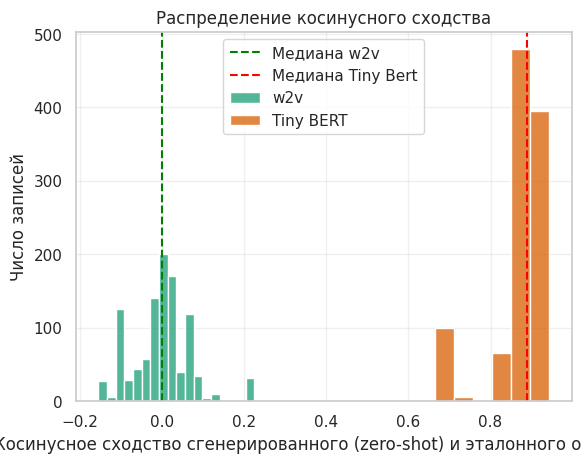

In [103]:
sns.histplot(data = ud_df['zero_shot_desc_sim'], bins=18, label='w2v')
sns.histplot(data = ud_df['zero_shot_bert_desc_sim'], bins=6, label='Tiny BERT')
w2v_xmedian = np.median(ud_df['zero_shot_desc_sim'])
bert_xmedian = np.median(ud_df['zero_shot_bert_desc_sim'])
plt.axvline(w2v_xmedian, color='green', linestyle='--', label='Медиана w2v')
plt.axvline(bert_xmedian, color='red', linestyle='--', label='Медиана Tiny Bert')

plt.title("Распределение косинусного сходства")
plt.xlabel("Косинусное сходство сгенерированного (zero-shot) и эталонного описания")
plt.ylabel("Число записей")
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

#### few-shot

Как следует из названия техники, few-shot подразумевает, что мы даем модели несколько примеров, по которым она должна понять, в каком формате (и/или какого рода информацию) мы ожидаем получить в ответ на запрос. Эти примеры подаются как часть промпта. Можно также встретить понятия one-shot (один пример), two-shot (два примера) и т.д. Это частные случаи few-shot.

Попробуем развить предыдущий пример, используя как эталонный вариант ответа результат при температуре 0.7 для дисциплины "Язык Python для анализа данных".

In [76]:
import numpy as np

courses = ["Машинное обучение",
           "Современные инструменты для анализа данных",
           "Методы визуализации данных"]

messages = [
	[{
		"role": "user",
		"content": """Запрос: Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины Язык Python для анализа данных. Разделов должно быть не более 8.
Ответ:
   Тема 1: Введение в Python для анализа данных
- Обзор Python и его применения в анализе данных
- Установка и настройка Python и основных библиотек (NumPy, Pandas, Matplotlib, etc.)
- Основы синтаксиса Python

Тема 2: Основы анализа данных
- Типы данных и структуры данных в Python
- Обработка и очистка данных
- Работа с большими данными

Тема 3: Анализ данных с помощью NumPy
- Введение в NumPy
- Массивы и векторы
- Операции над массивами
- Функции и методы NumPy

Тема 4: Анализ данных с помощью Pandas
- Введение в Pandas
- Сериалы и ДатаФреймы
- Обработка и манипулирование данными
- Агрегация и групповые операции

Тема 5: Визуализация данных с помощью Matplotlib и Seaborn
- Введение в Matplotlib
- Создание простых графиков
- Настройка стиля и темы
- Введение в Seaborn

Тема 6: Статистический анализ данных
- Введение в статистический анализ
- Работа с вероятностями и распределениями
- Основные статистические тесты

Тема 7: Машинное обучение и анализ данных
- Введение в машинное обучение
- Классификация и регрессия
- Искусственные нейронные сети

Тема 8: Проекты и применение знаний
- Создание проектов по анализу данных
- Презентация результатов анализа
- Обсуждение практического применения знаний в реальных ситуациях

Запрос: Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины {}. Разделов должно быть не более 8."""
.format(course)
	}] for course in courses
]

print(messages)

# перебирать температуры выше 1 не будем, там все плохо
temperatures = np.arange(0.3,0.8,0.1)


for i, message in enumerate(messages):

    for temp in temperatures:
        print(f"\n{'*'*20} {courses[i]}: temperature = {temp} {'*'*20}\n")

        completion = client.chat.completions.create(
            model="mistralai/Mistral-Nemo-Instruct-2407",
            messages=message,
            max_tokens=500,
            temperature=temp
        )

        print(completion.choices[0].message.content)

[[{'role': 'user', 'content': 'Запрос: Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины Язык Python для анализа данных. Разделов должно быть не более 8.\nОтвет:\n   Тема 1: Введение в Python для анализа данных\n- Обзор Python и его применения в анализе данных\n- Установка и настройка Python и основных библиотек (NumPy, Pandas, Matplotlib, etc.)\n- Основы синтаксиса Python\n\nТема 2: Основы анализа данных\n- Типы данных и структуры данных в Python\n- Обработка и очистка данных\n- Работа с большими данными\n\nТема 3: Анализ данных с помощью NumPy\n- Введение в NumPy\n- Массивы и векторы\n- Операции над массивами\n- Функции и методы NumPy\n\nТема 4: Анализ данных с помощью Pandas\n- Введение в Pandas\n- Сериалы и ДатаФреймы\n- Обработка и манипулирование данными\n- Агрегация и групповые операции\n\nТема 5: Визуализация данных с помощью Matplotlib и Seaborn\n- Введение в Matplotlib\n- Создание простых графиков\n- Настройка стиля и темы\n- Введение в Seaborn\n\nТем

Если показывать модели пример запроса и эталонный ответ, то наиболее близкие к правде ответы получаются при самых низких температурах. Возможно, ниже 0.3 было бы еще грамотнее. Зато при более высоких модели не хватает токенов и появляется много подробностей, которые, возможно, излишни.

Напишите функцию `mistral_one_shot()`, которая принимает на вход название дисциплины, объект клиента и значение температуры, а возвращает содержание дисциплины.

Аналогично предыдущему разделу, сгенерируйте содержание для выбранных 100 дисциплин (или всех). Затем предобработайте данные и проведите векторизацию обоими векторайзерами.

In [77]:
def mistral_one_shot(course, cli, temp, prompt):
    message = [
      {
        "role": "user",
        "content": prompt,
      }
    ]

    completion = cli.chat.completions.create(
            model="mistralai/Mistral-Nemo-Instruct-2407",
            messages=message,
            max_tokens=500,
            temperature=temp
    )

    return completion.choices[0].message.content

In [78]:
prompt = """Запрос: Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины "Философия". Разделов должно быть не более 8.
Ответ:
Мышление и предметный мир. Соматическая определенность мышления. Социальная определенность мышления. Структуры мышления. Антропоцентризм - постгуманизм - трансгуманизм.. Критическое мышление как задача философии, науки, искусства, повседневных практик.. Мышление природы: от натурфилософии до математического естествознания.. Нейронаука о мышлении и сознании человека. Проблемы биополитики.. Способы и границы систематизации предметов мышления: логика, категориальные структуры.. Субъект мышления и проблема достоверности.. Телесность и аффективность в мышлении.. Техники управления, контроля, манипуляции: возможности распознавания, практики сопротивления.. Этическое измерение науки, искусства, повседневности.. Я и Другой: признание, понимание, коммуникация.

Запрос: Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины "{}". Разделов должно быть не более 8."""


ud['one_shot_contents'] = ud['course_title'].progress_apply(lambda course: mistral_one_shot(course, client, 0.3, prompt.format(course)))

  0%|          | 0/100 [00:00<?, ?it/s]

In [105]:
ud_df = ud_df.merge(ud[['course_title', 'one_shot_contents']], on='course_title', how='inner')

# пример результата после добавления столбца с генерацией
print(ud_df.shape)
ud_df.sample(3, random_state=42)

(1046, 30)


,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,processed_contents,...,zero_shot_embed_contents,zero_shot_bert_contents,zero_shot_cont_sim,zero_shot_bert_cont_sim,zero_shot_description,zero_shot_embed_desc,zero_shot_bert_desc,zero_shot_desc_sim,zero_shot_bert_desc_sim,one_shot_contents
773,15443,Моделирование оптических процессов,Что такое фотоника? На наш взгляд это очень пе...,6909,Бизнес-информатика,bachelor,2020,ОГНП 7: Фотоника,Введение в методы численной электродинамики. О...,"[введение, метод, численный, электродинамика, ...",...,"[-0.3239396360658464, 0.015398795574548698, -0...","[0.012035356, 0.026579993, -0.01010953, -0.022...",0.039844,0.858912,"Дисциплина ""Моделирование оптических процессов...","[-0.34047546362298786, -0.0004351686919497382,...","[0.014998405, 0.044426706, -0.0020775623, -0.0...",-0.097422,0.898788,1. Введение в моделирование оптических процесс...
280,7593,Техническая термодинамика и теплопередача,"Представлены начала термодинамики, методы расч...",7311,Низкотемпературная техника и энергетика,bachelor,2019,Модуль обязательных дисциплин,Подобие и моделирование процессов конвективног...,"[подобие, моделирование, процесс, конвективный...",...,"[-0.34153428764653143, 0.003621533189144292, -...","[0.023301844, -0.0024123508, -0.0058031487, -0...",-0.040776,0.855769,Техническая термодинамика и теплопередача - эт...,"[-0.3511383946913241, 0.01553397891462345, -0....","[0.032178573, 0.029541641, -0.0034104057, -0.0...",0.023183,0.888753,1. Введение в техническую термодинамику: основ...
629,14936,Культурные подходы к цифровым практикам,Основная задача данного курса - предложить ра...,6987,Инфохимия / Infochemistry,master,2020,Факультативные дисциплины,"Библиотеки, архивы, энциклопедии, история big...","[библиотека, архив, энциклопедия, история, игр...",...,"[-0.2955086183082312, 0.0009245519029112378, -...","[0.036967784, 0.0038710928, 0.07892606, 0.0360...",0.100185,0.856196,"Дисциплина ""Культурные подходы к цифровым прак...","[-0.32343468047607127, -0.0002566351595579324,...","[0.037648458, 0.012171812, 0.04091286, 0.00619...",-0.097526,0.851397,1. Введение в культурные подходы к цифровым пр...


In [106]:
ud_df['one_shot_embed_contents'] = ud_df['one_shot_contents'].apply(lambda x: embed(x, w2v_model))
ud_df['one_shot_bert_contents'] = ud_df['one_shot_contents'].apply(lambda x: bert_model.encode(x))

# пример результата обработки
ud_df.sample(3, random_state=42)

,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,processed_contents,...,zero_shot_cont_sim,zero_shot_bert_cont_sim,zero_shot_description,zero_shot_embed_desc,zero_shot_bert_desc,zero_shot_desc_sim,zero_shot_bert_desc_sim,one_shot_contents,one_shot_embed_contents,one_shot_bert_contents
773,15443,Моделирование оптических процессов,Что такое фотоника? На наш взгляд это очень пе...,6909,Бизнес-информатика,bachelor,2020,ОГНП 7: Фотоника,Введение в методы численной электродинамики. О...,"[введение, метод, численный, электродинамика, ...",...,0.039844,0.858912,"Дисциплина ""Моделирование оптических процессов...","[-0.34047546362298786, -0.0004351686919497382,...","[0.014998405, 0.044426706, -0.0020775623, -0.0...",-0.097422,0.898788,1. Введение в моделирование оптических процесс...,"[-0.3475777425437138, 0.015585774483785418, -0...","[-0.005390102, 0.032097194, 0.009014256, -0.02..."
280,7593,Техническая термодинамика и теплопередача,"Представлены начала термодинамики, методы расч...",7311,Низкотемпературная техника и энергетика,bachelor,2019,Модуль обязательных дисциплин,Подобие и моделирование процессов конвективног...,"[подобие, моделирование, процесс, конвективный...",...,-0.040776,0.855769,Техническая термодинамика и теплопередача - эт...,"[-0.3511383946913241, 0.01553397891462345, -0....","[0.032178573, 0.029541641, -0.0034104057, -0.0...",0.023183,0.888753,1. Введение в техническую термодинамику: основ...,"[-0.3917808232354847, -0.005238808476715349, -...","[0.016359108, 0.0011420802, 0.004952487, -0.03..."
629,14936,Культурные подходы к цифровым практикам,Основная задача данного курса - предложить ра...,6987,Инфохимия / Infochemistry,master,2020,Факультативные дисциплины,"Библиотеки, архивы, энциклопедии, история big...","[библиотека, архив, энциклопедия, история, игр...",...,0.100185,0.856196,"Дисциплина ""Культурные подходы к цифровым прак...","[-0.32343468047607127, -0.0002566351595579324,...","[0.037648458, 0.012171812, 0.04091286, 0.00619...",-0.097526,0.851397,1. Введение в культурные подходы к цифровым пр...,"[-0.32653915052600113, -0.0022886836781372934,...","[0.034726635, 0.0005062732, 0.052855898, 0.004..."


In [107]:
ud_df['one_shot_cont_sim'] = ud_df.apply(lambda x: cosine_similarity(x["one_shot_embed_contents"], x["embed_contents"]), axis=1)
ud_df['one_shot_bert_cont_sim'] = ud_df.apply(lambda x: cosine_similarity(x["one_shot_bert_contents"], x["bert_contents"]), axis=1)

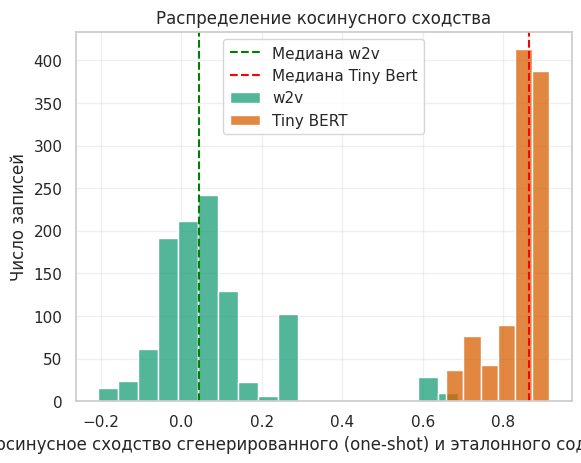

In [112]:
sns.histplot(data = ud_df['one_shot_cont_sim'], bins=18, label='w2v')
sns.histplot(data = ud_df['one_shot_bert_cont_sim'], bins=6, label='Tiny BERT')
w2v_xmedian = np.median(ud_df['one_shot_cont_sim'])
bert_xmedian = np.median(ud_df['one_shot_bert_cont_sim'])
plt.axvline(w2v_xmedian, color='green', linestyle='--', label='Медиана w2v')
plt.axvline(bert_xmedian, color='red', linestyle='--', label='Медиана Tiny Bert')

plt.title("Распределение косинусного сходства")
plt.xlabel("Косинусное сходство сгенерированного (one-shot) и эталонного содержания")
plt.ylabel("Число записей")
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()


Повторите этот пайплайн для генерации краткого описания дисциплины (`description`) в технике `few-shot`.

In [83]:
prompt = """Запрос: Представь, что ты преподаватель в университете. Создай короткое описание для дисциплины "Философия".
Ответ:
Курс «Философия» даёт целостное представление о специфике философии как актуальной формы мышления, о месте и роли философствования в различных средах: повседневной, социальной, коммуникационной, научной.Этот курс для тех, кто хочет узнать, к примеру, о том, что осталось в нашем мышлении неизменным со времен античности, и почему наука, какой мы знаем ее сегодня, не появилась бы без Декарта. Философия для тех, кому важно знать, как избавиться от ошибочных суждений, развить критическое мышление и попробовать себя в роли мастера аргументации в режиме и оффлайн, и онлайн.

Запрос: Представь, что ты преподаватель в университете. Создай короткое описание для дисциплины "{}"."""


ud['one_shot_description'] = ud['course_title'].progress_apply(lambda course: mistral_one_shot(course, client, 0.3, prompt.format(course)))

  0%|          | 0/100 [00:00<?, ?it/s]

In [108]:
ud_df = ud_df.merge(ud[['course_title', 'one_shot_description']], on='course_title', how='inner')

# пример результата после добавления столбца с генерацией
print(ud_df.shape)
ud_df.sample(3, random_state=42)

(1046, 35)


,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,processed_contents,...,zero_shot_embed_desc,zero_shot_bert_desc,zero_shot_desc_sim,zero_shot_bert_desc_sim,one_shot_contents,one_shot_embed_contents,one_shot_bert_contents,one_shot_cont_sim,one_shot_bert_cont_sim,one_shot_description
773,15443,Моделирование оптических процессов,Что такое фотоника? На наш взгляд это очень пе...,6909,Бизнес-информатика,bachelor,2020,ОГНП 7: Фотоника,Введение в методы численной электродинамики. О...,"[введение, метод, численный, электродинамика, ...",...,"[-0.34047546362298786, -0.0004351686919497382,...","[0.014998405, 0.044426706, -0.0020775623, -0.0...",-0.097422,0.898788,1. Введение в моделирование оптических процесс...,"[-0.3475777425437138, 0.015585774483785418, -0...","[-0.005390102, 0.032097194, 0.009014256, -0.02...",0.043901,0.887375,"Курс ""Моделирование оптических процессов"" посв..."
280,7593,Техническая термодинамика и теплопередача,"Представлены начала термодинамики, методы расч...",7311,Низкотемпературная техника и энергетика,bachelor,2019,Модуль обязательных дисциплин,Подобие и моделирование процессов конвективног...,"[подобие, моделирование, процесс, конвективный...",...,"[-0.3511383946913241, 0.01553397891462345, -0....","[0.032178573, 0.029541641, -0.0034104057, -0.0...",0.023183,0.888753,1. Введение в техническую термодинамику: основ...,"[-0.3917808232354847, -0.005238808476715349, -...","[0.016359108, 0.0011420802, 0.004952487, -0.03...",-0.043364,0.871641,"Курс ""Техническая термодинамика и теплопередач..."
629,14936,Культурные подходы к цифровым практикам,Основная задача данного курса - предложить ра...,6987,Инфохимия / Infochemistry,master,2020,Факультативные дисциплины,"Библиотеки, архивы, энциклопедии, история big...","[библиотека, архив, энциклопедия, история, игр...",...,"[-0.32343468047607127, -0.0002566351595579324,...","[0.037648458, 0.012171812, 0.04091286, 0.00619...",-0.097526,0.851397,1. Введение в культурные подходы к цифровым пр...,"[-0.32653915052600113, -0.0022886836781372934,...","[0.034726635, 0.0005062732, 0.052855898, 0.004...",0.094039,0.862422,"Курс ""Культурные подходы к цифровым практикам""..."


In [109]:
ud_df['one_shot_embed_desc'] = ud_df['one_shot_description'].apply(lambda x: embed(x, w2v_model))
ud_df['one_shot_bert_desc'] = ud_df['one_shot_description'].apply(lambda x: bert_model.encode(x))

# пример результата обработки
ud_df.sample(3, random_state=42)

,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,processed_contents,...,zero_shot_desc_sim,zero_shot_bert_desc_sim,one_shot_contents,one_shot_embed_contents,one_shot_bert_contents,one_shot_cont_sim,one_shot_bert_cont_sim,one_shot_description,one_shot_embed_desc,one_shot_bert_desc
773,15443,Моделирование оптических процессов,Что такое фотоника? На наш взгляд это очень пе...,6909,Бизнес-информатика,bachelor,2020,ОГНП 7: Фотоника,Введение в методы численной электродинамики. О...,"[введение, метод, численный, электродинамика, ...",...,-0.097422,0.898788,1. Введение в моделирование оптических процесс...,"[-0.3475777425437138, 0.015585774483785418, -0...","[-0.005390102, 0.032097194, 0.009014256, -0.02...",0.043901,0.887375,"Курс ""Моделирование оптических процессов"" посв...","[-0.34385134032345377, -0.010335047397120434, ...","[0.012785937, 0.056016363, -0.0154498955, -0.0..."
280,7593,Техническая термодинамика и теплопередача,"Представлены начала термодинамики, методы расч...",7311,Низкотемпературная техника и энергетика,bachelor,2019,Модуль обязательных дисциплин,Подобие и моделирование процессов конвективног...,"[подобие, моделирование, процесс, конвективный...",...,0.023183,0.888753,1. Введение в техническую термодинамику: основ...,"[-0.3917808232354847, -0.005238808476715349, -...","[0.016359108, 0.0011420802, 0.004952487, -0.03...",-0.043364,0.871641,"Курс ""Техническая термодинамика и теплопередач...","[-0.35736898402523304, 0.0004811328459477265, ...","[0.061465017, 0.03933729, -0.01987707, 0.00247..."
629,14936,Культурные подходы к цифровым практикам,Основная задача данного курса - предложить ра...,6987,Инфохимия / Infochemistry,master,2020,Факультативные дисциплины,"Библиотеки, архивы, энциклопедии, история big...","[библиотека, архив, энциклопедия, история, игр...",...,-0.097526,0.851397,1. Введение в культурные подходы к цифровым пр...,"[-0.32653915052600113, -0.0022886836781372934,...","[0.034726635, 0.0005062732, 0.052855898, 0.004...",0.094039,0.862422,"Курс ""Культурные подходы к цифровым практикам""...","[-0.35609899039657134, 0.001917225500250965, -...","[0.04468292, 0.012175345, 0.05835715, 0.007605..."


In [110]:
ud_df['one_shot_desc_sim'] = ud_df.apply(lambda x: cosine_similarity(x["one_shot_embed_desc"], x["embed_description"]), axis=1)
ud_df['one_shot_bert_desc_sim'] = ud_df.apply(lambda x: cosine_similarity(x["one_shot_bert_desc"], x["bert_description"]), axis=1)

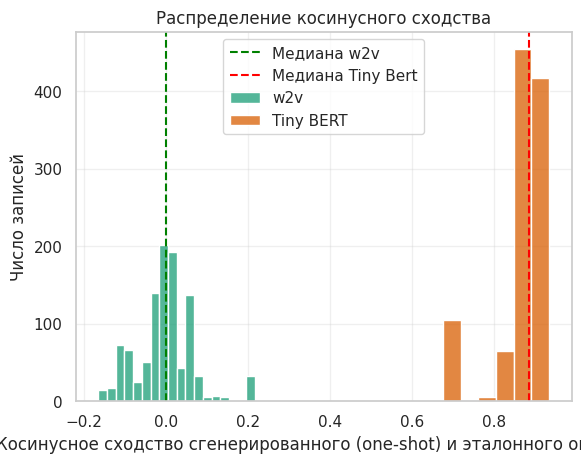

In [113]:
sns.histplot(data = ud_df['one_shot_desc_sim'], bins=18, label='w2v')
sns.histplot(data = ud_df['one_shot_bert_desc_sim'], bins=6, label='Tiny BERT')
w2v_xmedian = np.median(ud_df['one_shot_desc_sim'])
bert_xmedian = np.median(ud_df['one_shot_bert_desc_sim'])
plt.axvline(w2v_xmedian, color='green', linestyle='--', label='Медиана w2v')
plt.axvline(bert_xmedian, color='red', linestyle='--', label='Медиана Tiny Bert')

plt.title("Распределение косинусного сходства")
plt.xlabel("Косинусное сходство сгенерированного (one-shot) и эталонного описания")
plt.ylabel("Число записей")
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

## Задача 3 – Проанализировать результаты

Постройте визуализации для оценки результатов генерации искусственных данных по дисциплинам. В каждом пункте оценивайте результаты генерации в обеих техниках. Для каждого пункта напишите краткий вывод.

1. Постройте гистограмму, показывающую распределения сходств краткого описания с эталонным (человеческим) и содержания. Сравните результаты для обоих векторайзеров.

Построим гистограмму для техники zero-shot. Вот вариант для краткого описания:

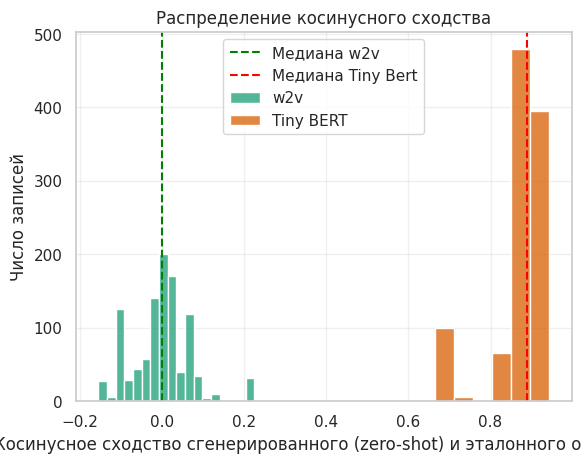

In [122]:
sns.histplot(data = ud_df['zero_shot_desc_sim'], bins=18, label='w2v')
sns.histplot(data = ud_df['zero_shot_bert_desc_sim'], bins=6, label='Tiny BERT')
w2v_xmedian = np.median(ud_df['zero_shot_desc_sim'])
bert_xmedian = np.median(ud_df['zero_shot_bert_desc_sim'])
plt.axvline(w2v_xmedian, color='green', linestyle='--', label='Медиана w2v')
plt.axvline(bert_xmedian, color='red', linestyle='--', label='Медиана Tiny Bert')

plt.title("Распределение косинусного сходства")
plt.xlabel("Косинусное сходство сгенерированного (zero-shot) и эталонного описания")
plt.ylabel("Число записей")
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

Вот вариант для содержания:

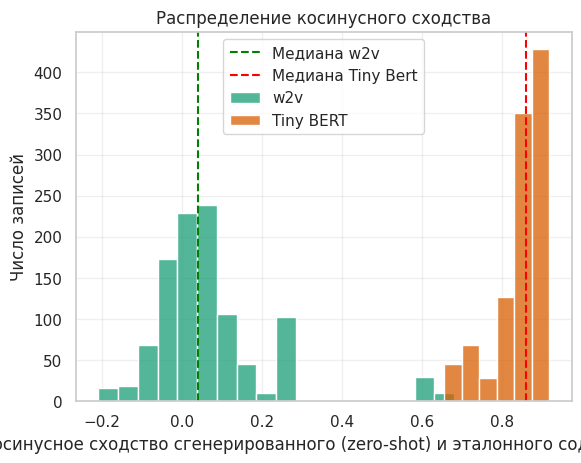

In [123]:
sns.histplot(data = ud_df['zero_shot_cont_sim'], bins=18, label='w2v')
sns.histplot(data = ud_df['zero_shot_bert_cont_sim'], bins=6, label='Tiny BERT')
w2v_xmedian = np.median(ud_df['zero_shot_cont_sim'])
bert_xmedian = np.median(ud_df['zero_shot_bert_cont_sim'])
plt.axvline(w2v_xmedian, color='green', linestyle='--', label='Медиана w2v')
plt.axvline(bert_xmedian, color='red', linestyle='--', label='Медиана Tiny Bert')

plt.title("Распределение косинусного сходства")
plt.xlabel("Косинусное сходство сгенерированного (zero-shot) и эталонного содержания")
plt.ylabel("Число записей")
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

Построим гистограмму для техники few-shot (one-shot). Вот вариант для краткого описания:

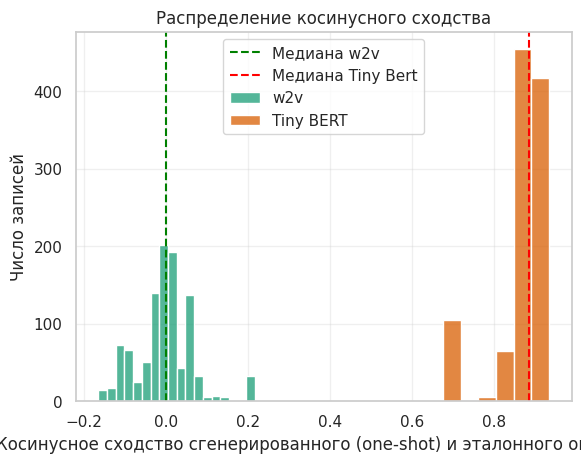

In [121]:
sns.histplot(data = ud_df['one_shot_desc_sim'], bins=18, label='w2v')
sns.histplot(data = ud_df['one_shot_bert_desc_sim'], bins=6, label='Tiny BERT')
w2v_xmedian = np.median(ud_df['one_shot_desc_sim'])
bert_xmedian = np.median(ud_df['one_shot_bert_desc_sim'])
plt.axvline(w2v_xmedian, color='green', linestyle='--', label='Медиана w2v')
plt.axvline(bert_xmedian, color='red', linestyle='--', label='Медиана Tiny Bert')

plt.title("Распределение косинусного сходства")
plt.xlabel("Косинусное сходство сгенерированного (one-shot) и эталонного описания")
plt.ylabel("Число записей")
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

Вот вариант для содержания:

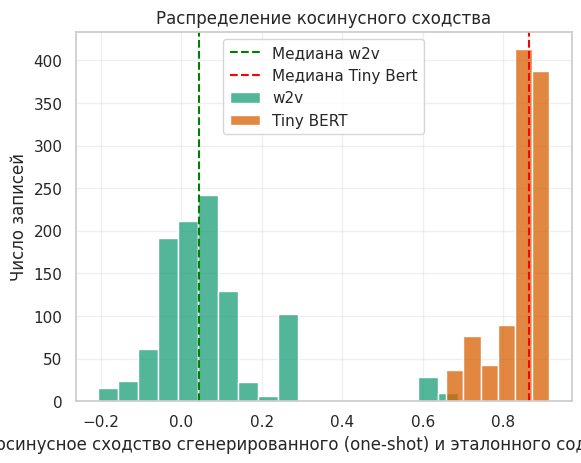

In [119]:
sns.histplot(data = ud_df['one_shot_cont_sim'], bins=18, label='w2v')
sns.histplot(data = ud_df['one_shot_bert_cont_sim'], bins=6, label='Tiny BERT')
w2v_xmedian = np.median(ud_df['one_shot_cont_sim'])
bert_xmedian = np.median(ud_df['one_shot_bert_cont_sim'])
plt.axvline(w2v_xmedian, color='green', linestyle='--', label='Медиана w2v')
plt.axvline(bert_xmedian, color='red', linestyle='--', label='Медиана Tiny Bert')

plt.title("Распределение косинусного сходства")
plt.xlabel("Косинусное сходство сгенерированного (one-shot) и эталонного содержания")
plt.ylabel("Число записей")
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

Видно, что:

*   Для w2v косинусное сходство в основном сосредоточено около нуля, что указывает на слабую корреляцию между описанием и содержанием.
*   Для Tiny BERT распределение сосредоточено в области высоких значений косинусного сходства (ближе к 1), что указывает на значительно более сильное соответствие между описанием и содержанием.

Таким образом, Tiny BERT демонстрирует более высокую степень схожести между кратким описанием и содержанием по сравнению с w2v. Вероятно, это связано с тем, что это предобученная модель, в которой использовалось значительно больше слов, чем в w2v, который мы обучали самостоятельно.

2. Оцените среднее косинусное сходство содержания и краткого описания, сгенерированных человеком и языковой моделью, в разрезе по уровням образования (`qualification`). Сравните результаты для обоих векторайзеров.

Сначала посчитаем для содержания:

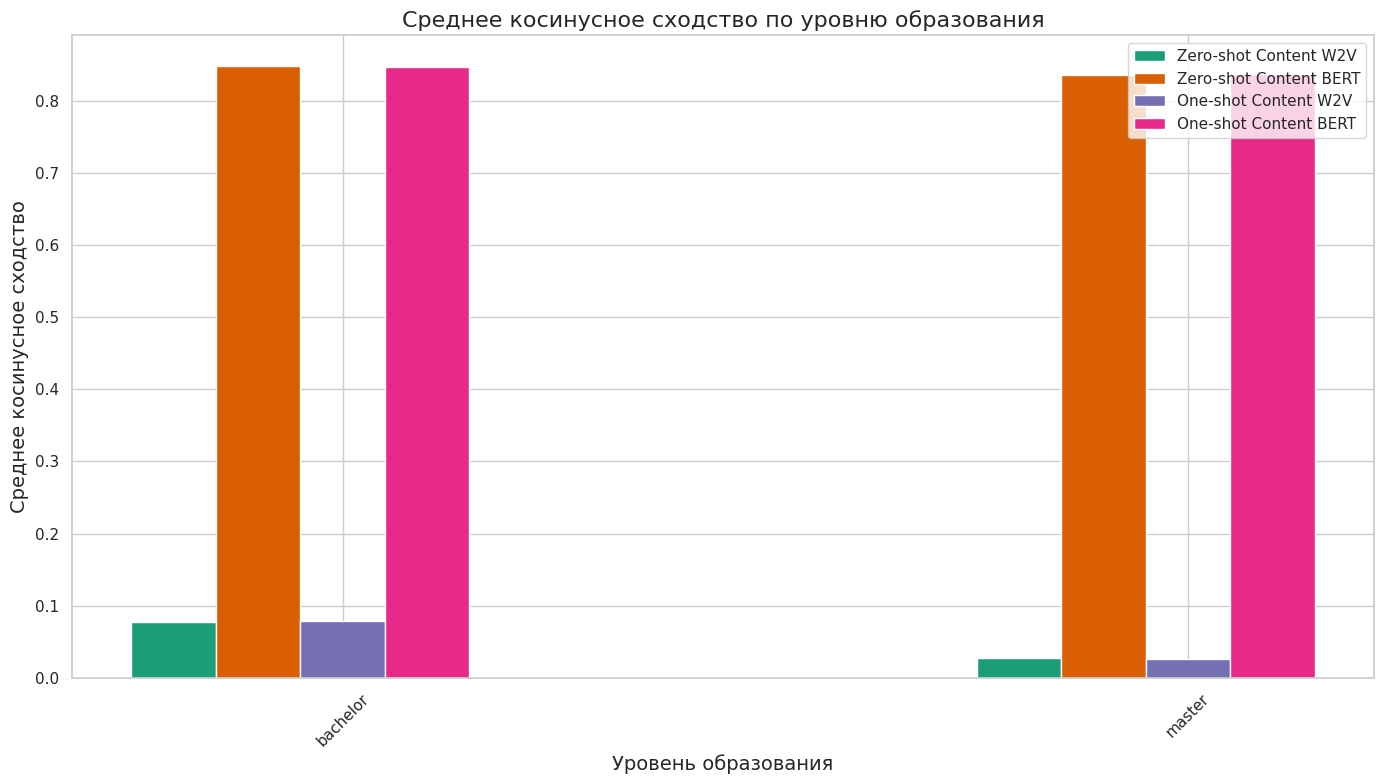

In [129]:
zero_shot_content_w2v_sim = ud_df.groupby(['qualification'])['zero_shot_cont_sim'].mean()
zero_shot_content_bert_sim = ud_df.groupby(['qualification'])['zero_shot_bert_cont_sim'].mean()
one_shot_content_w2v_sim = ud_df.groupby(['qualification'])['one_shot_cont_sim'].mean()
one_shot_content_bert_sim = ud_df.groupby(['qualification'])['one_shot_bert_cont_sim'].mean()

qualifications = zero_shot_content_bert_sim.index
metrics = {
    'Zero-shot Content W2V': zero_shot_content_w2v_sim.values,
    'Zero-shot Content BERT': zero_shot_content_bert_sim.values,
    'One-shot Content W2V': one_shot_content_w2v_sim.values,
    'One-shot Content BERT': one_shot_content_bert_sim.values,
}

bar_width = 0.1
x = np.arange(len(qualifications))

plt.figure(figsize=(14, 8))
for i, (metric_name, values) in enumerate(metrics.items()):
    plt.bar(x + i * bar_width, values, width=bar_width, label=metric_name)

plt.title('Среднее косинусное сходство по уровню образования', fontsize=16)
plt.xlabel('Уровень образования', fontsize=14)
plt.ylabel('Среднее косинусное сходство', fontsize=14)
plt.xticks(x + bar_width * len(metrics) / 2, qualifications, rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

Теперь для краткого описания:

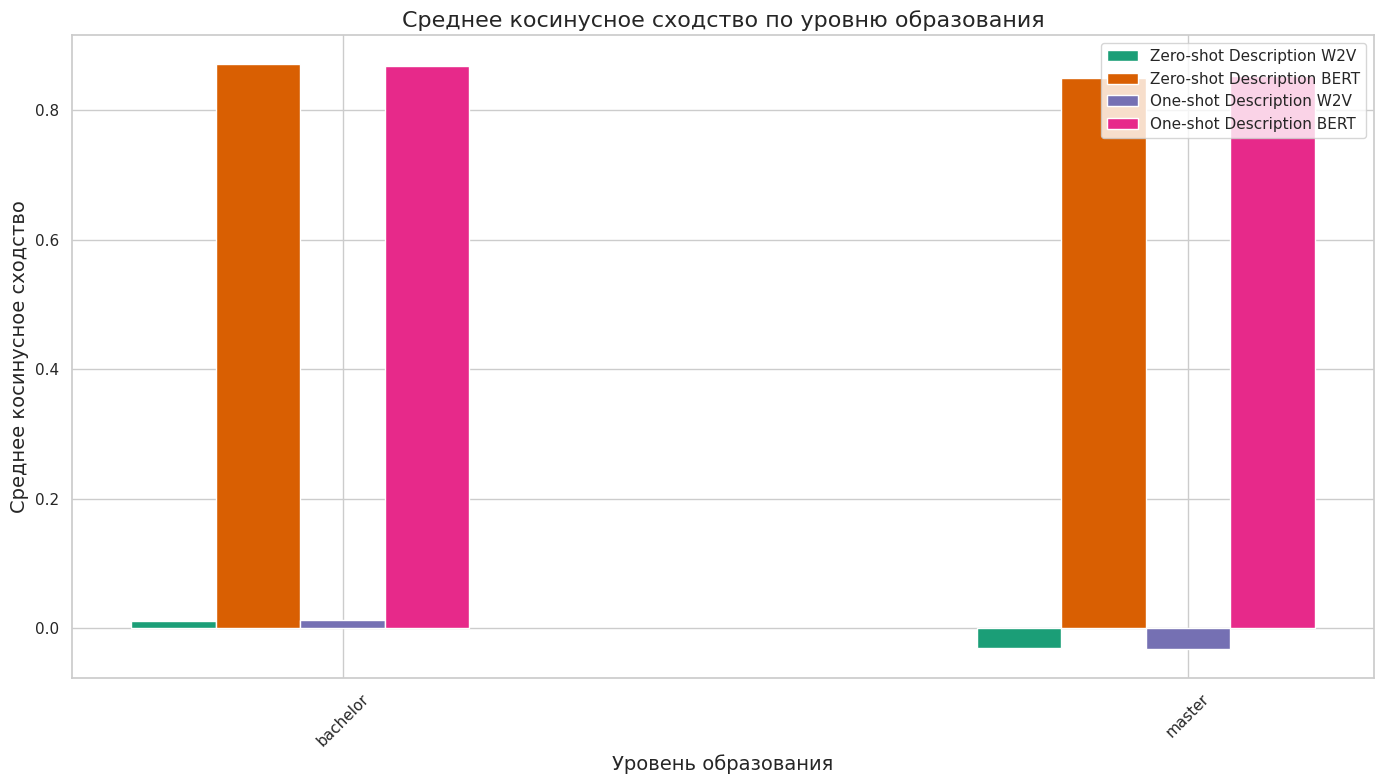

In [131]:
zero_shot_description_w2v_sim = ud_df.groupby(['qualification'])['zero_shot_desc_sim'].mean()
zero_shot_description_bert_sim = ud_df.groupby(['qualification'])['zero_shot_bert_desc_sim'].mean()
one_shot_description_w2v_sim = ud_df.groupby(['qualification'])['one_shot_desc_sim'].mean()
one_shot_description_bert_sim = ud_df.groupby(['qualification'])['one_shot_bert_desc_sim'].mean()

qualifications = zero_shot_content_bert_sim.index
metrics = {
    'Zero-shot Description W2V': zero_shot_description_w2v_sim.values,
    'Zero-shot Description BERT': zero_shot_description_bert_sim.values,
    'One-shot Description W2V': one_shot_description_w2v_sim.values,
    'One-shot Description BERT': one_shot_description_bert_sim.values,
}

bar_width = 0.1
x = np.arange(len(qualifications))

plt.figure(figsize=(14, 8))
for i, (metric_name, values) in enumerate(metrics.items()):
    plt.bar(x + i * bar_width, values, width=bar_width, label=metric_name)

plt.title('Среднее косинусное сходство по уровню образования', fontsize=16)
plt.xlabel('Уровень образования', fontsize=14)
plt.ylabel('Среднее косинусное сходство', fontsize=14)
plt.xticks(x + bar_width * len(metrics) / 2, qualifications, rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

Снова можем наблюдать значительную разницу в результатах работы векторайзеров: Tiny BERT с огромным отрывом демонстрирует бОльшую схожесть, чем наш w2v.

Также можно отметить, что для бакалаврских дисциплин сходство в среднем выше, чем для магистерских: это касается и BERT, и w2v. Вероятно, это связано с тем, что программ для бакалавров в целом больше.

Кроме того, для содержания сходство в среднем выше, чем для краткого описания - это особенно актуально для W2V.

3. Оцените среднее косинусное сходство содержания и краткого описания, сгенерированных человеком и языковой моделью, в разрезе по году (`start_year`). Сравните результаты для обоих векторайзеров.

Сначала посчитаем для содержания:

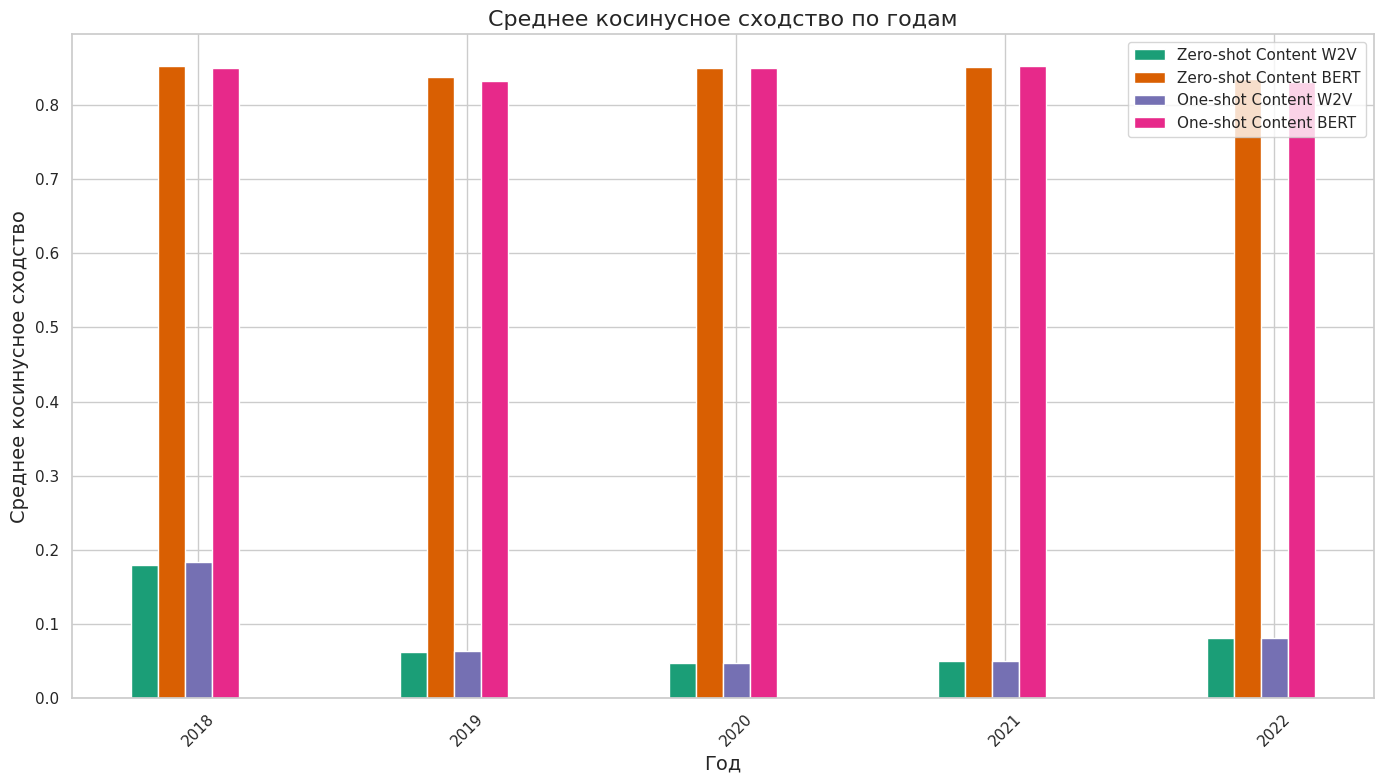

In [141]:
zero_shot_content_w2v_sim = ud_df.groupby(['start_year'])['zero_shot_cont_sim'].mean()
zero_shot_content_bert_sim = ud_df.groupby(['start_year'])['zero_shot_bert_cont_sim'].mean()
one_shot_content_w2v_sim = ud_df.groupby(['start_year'])['one_shot_cont_sim'].mean()
one_shot_content_bert_sim = ud_df.groupby(['start_year'])['one_shot_bert_cont_sim'].mean()

qualifications = zero_shot_content_bert_sim.index
metrics = {
    'Zero-shot Content W2V': zero_shot_content_w2v_sim.values,
    'Zero-shot Content BERT': zero_shot_content_bert_sim.values,
    'One-shot Content W2V': one_shot_content_w2v_sim.values,
    'One-shot Content BERT': one_shot_content_bert_sim.values,
}

bar_width = 0.1
x = np.arange(len(qualifications))

plt.figure(figsize=(14, 8))
for i, (metric_name, values) in enumerate(metrics.items()):
    plt.bar(x + i * bar_width, values, width=bar_width, label=metric_name)

plt.title('Среднее косинусное сходство по годам', fontsize=16)
plt.xlabel('Год', fontsize=14)
plt.ylabel('Среднее косинусное сходство', fontsize=14)
plt.xticks(x + bar_width * len(metrics) / 2, qualifications, rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

Теперь для краткого описания:

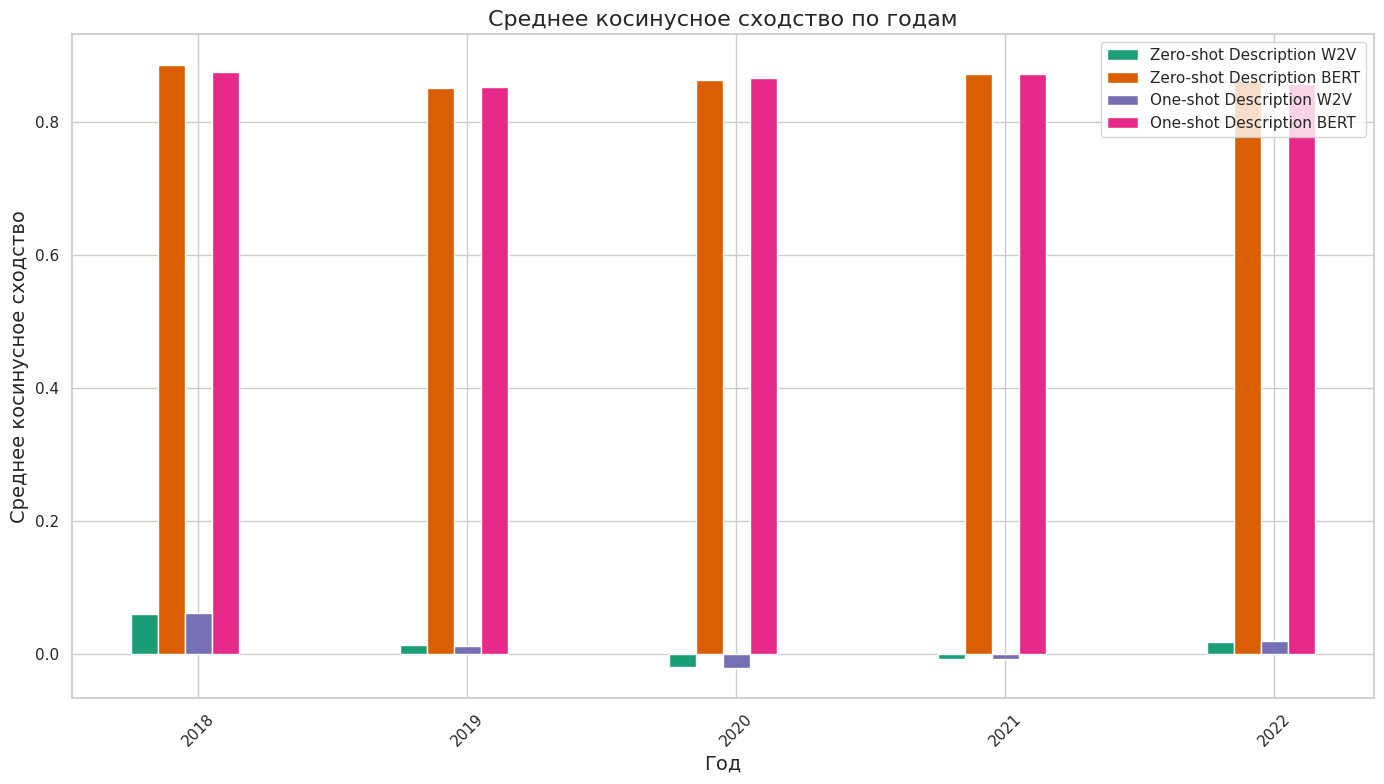

In [142]:
zero_shot_description_w2v_sim = ud_df.groupby(['start_year'])['zero_shot_desc_sim'].mean()
zero_shot_description_bert_sim = ud_df.groupby(['start_year'])['zero_shot_bert_desc_sim'].mean()
one_shot_description_w2v_sim = ud_df.groupby(['start_year'])['one_shot_desc_sim'].mean()
one_shot_description_bert_sim = ud_df.groupby(['start_year'])['one_shot_bert_desc_sim'].mean()

qualifications = zero_shot_content_bert_sim.index
metrics = {
    'Zero-shot Description W2V': zero_shot_description_w2v_sim.values,
    'Zero-shot Description BERT': zero_shot_description_bert_sim.values,
    'One-shot Description W2V': one_shot_description_w2v_sim.values,
    'One-shot Description BERT': one_shot_description_bert_sim.values,
}

bar_width = 0.1
x = np.arange(len(qualifications))

plt.figure(figsize=(14, 8))
for i, (metric_name, values) in enumerate(metrics.items()):
    plt.bar(x + i * bar_width, values, width=bar_width, label=metric_name)

plt.title('Среднее косинусное сходство по годам', fontsize=16)
plt.xlabel('Год', fontsize=14)
plt.ylabel('Среднее косинусное сходство', fontsize=14)
plt.xticks(x + bar_width * len(metrics) / 2, qualifications, rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

Сразу видно, что в сходство в 2018 году в среднем выше чем во все остальные года, особенно это касается w2v. Также интересно, что если для Tiny BERT результаты примерно одинаковые, то для w2v они могут очень сильно различаться в зависимости от года и уровня образования.

4. Оцените среднее косинусное сходство содержания и краткого описания, сгенерированных человеком и языковой моделью, в разрезе по уровням образования и годам, но только с помощью векторов  w2v.

<ipython-input-143-9b67d57f6486>:11: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  grouped_data = grouped_data.set_index(['start_year', 'qualification']).unstack(fill_value=0).stack().reset_index()


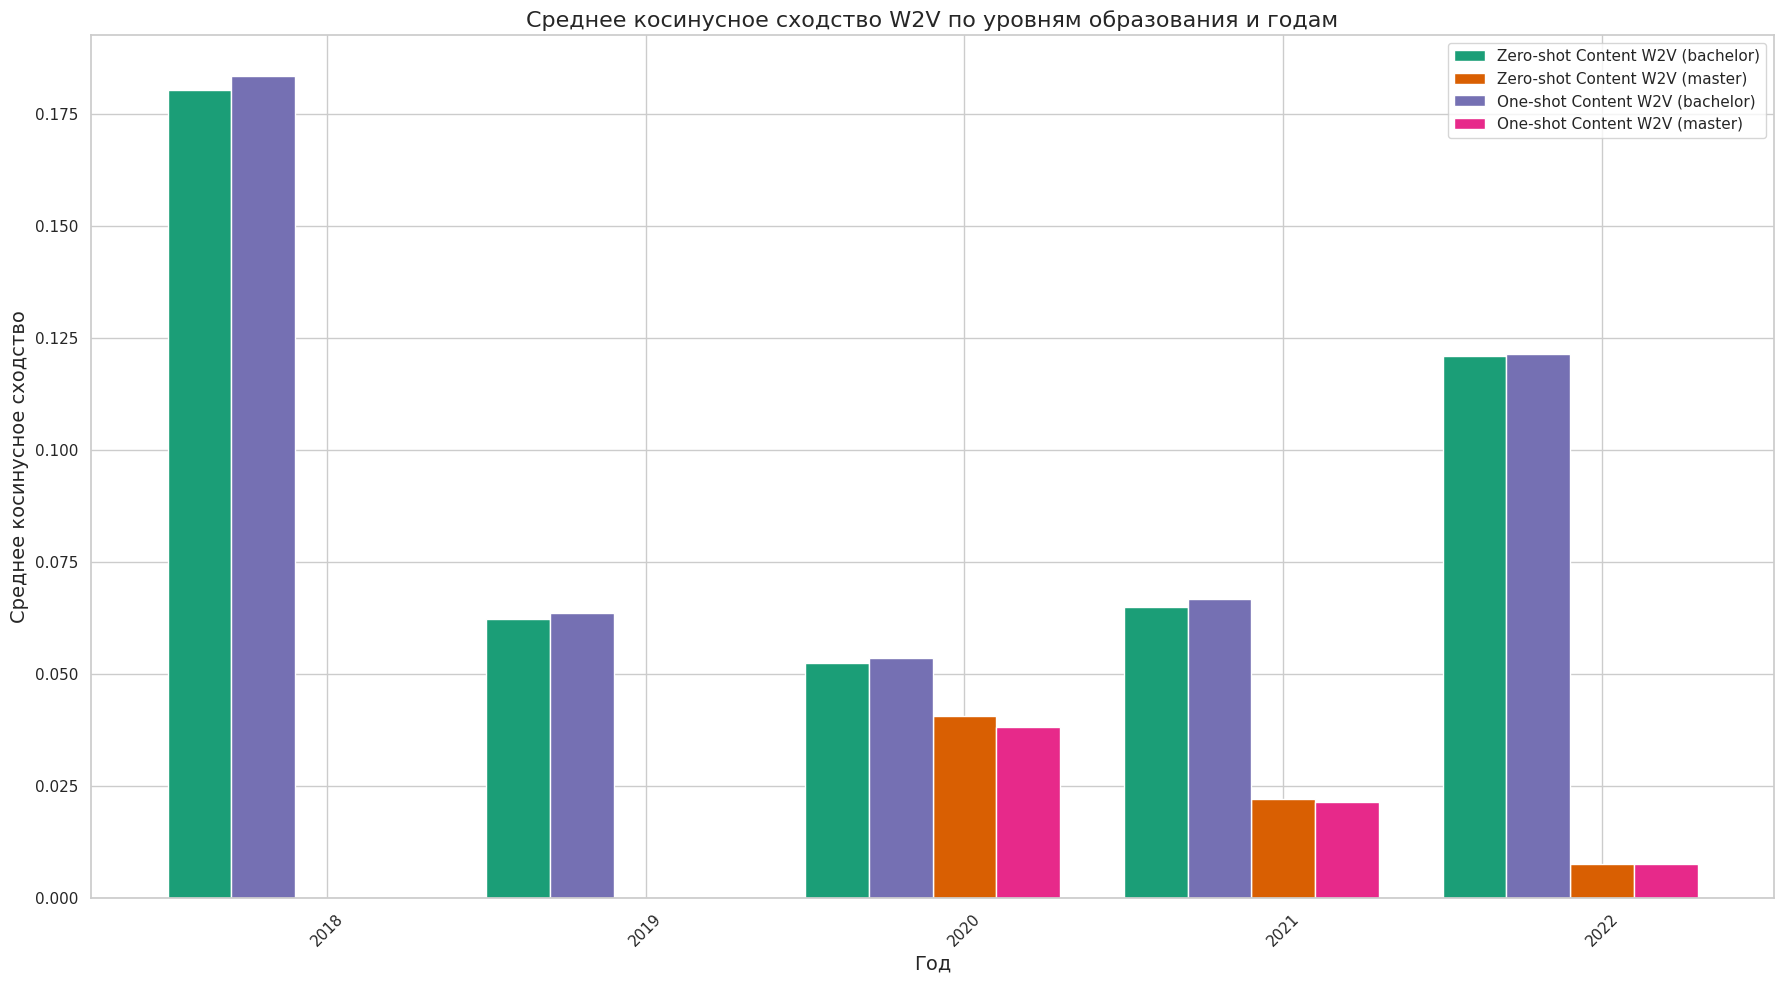

In [143]:
w2v_metrics = {
    'Zero-shot Content W2V': ud_df.groupby(['start_year', 'qualification'])['zero_shot_cont_sim'].mean(),
    'One-shot Content W2V': ud_df.groupby(['start_year', 'qualification'])['one_shot_cont_sim'].mean(),
}

grouped_data = pd.DataFrame(w2v_metrics).reset_index()

qualifications = grouped_data['qualification'].unique()
years = grouped_data['start_year'].unique()

grouped_data = grouped_data.set_index(['start_year', 'qualification']).unstack(fill_value=0).stack().reset_index()

bar_width = 0.2
x = np.arange(len(years))

plt.figure(figsize=(18, 10))

for i, metric_name in enumerate(w2v_metrics.keys()):
    for idx, qual in enumerate(qualifications):
        subset = grouped_data[grouped_data['qualification'] == qual]
        plt.bar(x + (i + idx * len(w2v_metrics)) * bar_width,
                subset[metric_name],
                width=bar_width,
                label=f"{metric_name} ({qual})")

plt.title('Среднее косинусное сходство W2V по уровням образования и годам', fontsize=16)
plt.xlabel('Год', fontsize=14)
plt.ylabel('Среднее косинусное сходство', fontsize=14)
plt.xticks(x + bar_width * (len(w2v_metrics) * len(qualifications)) / 2, years, rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()

plt.show()

По данному графику вновь можем убедиться, что в 2018 году оценки сходства от W2V значительно выше, чем в остальных годах. Также можно заметить, что для бакалаврских программ one-shot справляется чуть-чуть лучше (незначительно), а для магистерских – скорее наоборот.

Скорее всего, это связано с разницей в количестве программ, как уже упоминалось ранее.

5. Оцените средние значения сходства эталонных данных и генераций обеими техниками в разрезе по уровню образования (`qualification`). То есть постройте такую диграмму, по которой будет видно, для какого уровня образования какая из техник в среднем дает более близкий к эталонному контекст.

Диаграммы уже построены в пункте 2...



Средние значения сходства эталонных данных и генераций обеими техниками (Zero-shot и One-shot) в разрезе по уровням образования в целом показали схожие результаты. Вероятно, это связано с тем, что различия между подходами не являются значительными для данной выборки. Кроме того, методы используют одну и ту же модель, что может привести к сходным результатам при оценке качества текста.

Также возможно, что данные для разных уровней образования имеют схожую структуру или содержание, что нивелирует различия между подходами.

## Куда сдавать?

По инструкции в гитхаб – https://shy-question-39d.notion.site/1150ea832e418032bfc3d3e827c380fb?pvs=74

- К этой работе тестов нет.
- Эту работу можно выполнить с кем-нибудь в паре или в гордом одиночестве.
- Пул-реквест нужно сделать в ветку `lab4`. Если вас двое, то можно 1 или 2 пул-реквеста, главное – отметьте как-нибудь, что выполняли в паре.

**Устная защита работ не требуется, но вам могут быть заданы вопросы прямо в вашем пул-реквесте!**